In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

In [2]:
from qutip import *

In [3]:
class SystemParameters:
    
    def __init__(self):
        # Input variable
        
        self.init_system()
        self.init_operators()
        self.state_operators()
        
    def init_system(self):
        self.initial_pulse = True
        self.qubit_state_num = 3
        self.alpha = 0.224574
        self.freq_ge = 3.9225 #GHz
        self.ens = np.array([ 2*np.pi*ii*(self.freq_ge - 0.5*(ii-1)*self.alpha) for ii in np.arange(self.qubit_state_num)])
        
        self.mode_state_num = 3
        
        self.qm_g1 = 2*np.pi*0.075 #GHz
        self.mode1_freq = 6.11 #GHz
        self.mode1_ens = np.array([ 2*np.pi*ii*(self.mode1_freq) for ii in np.arange(self.mode_state_num)])
        
        self.qm_g2 = 2*np.pi*0.075 #GHz
        self.mode2_freq = 6.65 #GHz
        self.mode2_ens = np.array([ 2*np.pi*ii*(self.mode2_freq) for ii in np.arange(self.mode_state_num)])
        
        self.state_num = self.qubit_state_num * (self.mode_state_num**2)
        
        self.pts_per_period = 40
        self.dt = (1./self.mode2_freq)/self.pts_per_period
        self.total_time=200.
        self.steps = int(self.total_time/self.dt)+1
        self.tlist = np.linspace(0,self.total_time,self.steps)
        
    def update_total_time(self,total_time):
        self.total_time=total_time
        self.steps = int(self.total_time/self.dt)+1
        self.tlist = np.linspace(0,self.total_time,self.steps)
        
    def update_pts_per_period(self,pts_per_period):
        self.pts_per_period=pts_per_period
        self.dt = (1./self.mode_freq)/self.pts_per_period
        self.steps = int(self.total_time/self.dt)+1
        self.tlist = np.linspace(0,self.total_time,self.steps)
        
    def init_operators(self):
        # Create operator matrix in numpy array
        H_q = np.diag(self.ens)
        H_m1 = np.diag(self.mode1_ens)
        H_m2 = np.diag(self.mode2_ens)
        
        Q_x   = np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),-1)
        Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,self.qubit_state_num)),-1))
        Q_z   = np.diag(np.arange(0,self.qubit_state_num))
        
        M_x = np.diag(np.sqrt(np.arange(1,self.mode_state_num)),1)+np.diag(np.sqrt(np.arange(1,self.mode_state_num)),-1)
        
        self.I_q = np.identity(self.qubit_state_num)
        self.I_m = np.identity(self.mode_state_num)
        
        XI = np.kron(Q_x,np.kron(self.I_m,self.I_m))
        YI = np.kron(Q_y,np.kron(self.I_m,self.I_m))
        ZI = np.kron(Q_z,np.kron(self.I_m,self.I_m))
        
        self.ops = [XI,YI,ZI]
        
        self.Hx_op = XI
        self.Hy_op = YI
        self.Hz_op = ZI
        
        self.ops_len = len(self.ops)
        
        self.H0 = np.kron(H_q,np.kron(self.I_m,self.I_m)) + np.kron(self.I_q,np.kron(H_m1,self.I_m)) +\
            np.kron(self.I_q,np.kron(self.I_m,H_m2)) + self.qm_g1*np.kron(Q_x,np.kron(M_x,self.I_m)) +\
            self.qm_g2*np.kron(Q_x,np.kron(self.I_m,M_x))
       
    def state_operators(self):
        # State operators, used for output
        g_array= np.zeros(self.qubit_state_num)
        g_array[0] = 1
        g_vector = tensor(Qobj(np.array(g_array)),Qobj(self.I_m),Qobj(self.I_m))
        g_matrix = tensor(Qobj(np.diag(g_array)),Qobj(self.I_m),Qobj(self.I_m))

        e_array= np.zeros(self.qubit_state_num)
        e_array[1] = 1
        e_vector = tensor(Qobj(np.array(e_array)),Qobj(self.I_m),Qobj(self.I_m))
        e_matrix = tensor(Qobj(np.diag(e_array)),Qobj(self.I_m),Qobj(self.I_m))

        f_array= np.zeros(self.qubit_state_num)
        f_array[2] = 1
        f_vector = tensor(Qobj(np.array(f_array)),Qobj(self.I_m),Qobj(self.I_m))
        f_matrix = tensor(Qobj(np.diag(f_array)),Qobj(self.I_m),Qobj(self.I_m))
        
        
        H0 = Qobj(self.H0)
        
        self.g00 = H0.eigenstates()[1][0]*H0.eigenstates()[1][0].dag()
        self.e00 = H0.eigenstates()[1][1]*H0.eigenstates()[1][1].dag()
        self.g10 = H0.eigenstates()[1][2]*H0.eigenstates()[1][2].dag()
        self.g01 = H0.eigenstates()[1][3]*H0.eigenstates()[1][3].dag()
        self.f00 = H0.eigenstates()[1][4]*H0.eigenstates()[1][4].dag()
        self.e10 = H0.eigenstates()[1][5]*H0.eigenstates()[1][5].dag()
        self.e01 = H0.eigenstates()[1][6]*H0.eigenstates()[1][6].dag()
        self.g11 = H0.eigenstates()[1][8]*H0.eigenstates()[1][8].dag()

        
        self.gs = g_vector
        self.es = e_vector
        self.fs = f_vector

        return [self.g00,self.e00,self.g10,self.g01,self.f00,self.e10,self.e01,self.g11]
    
    
    def c_operators(self):
        # qubit coherence parameters

        T1_ge = 18000.0
        T1_ef = 7000.0
        T2_ge = 12000.0
        T2_ef = 12000.0
        T_ephi = 1/(1/T2_ge -1/(2*T1_ge))
        T_fphi = 1/(1/T2_ef -1/(2*T1_ef))
        
        # cavity coherence_parameters
        T1_cav1 = 4000.0
        T1_cav2 = 4000.0
        kappa1 = 1/T1_cav1 # cavity dissipation rate
        kappa2 = 1/T1_cav2 # cavity dissipation rate
        
        a1  = tensor(qeye(self.qubit_state_num),destroy(self.mode_state_num),qeye(self.mode_state_num))
        a2  = tensor(qeye(self.qubit_state_num),qeye(self.mode_state_num),destroy(self.mode_state_num))

        c_ops = (1/T1_ge)*lindblad_dissipator(self.gs*self.es.dag()) +   (1/T1_ef)*lindblad_dissipator(self.es*self.fs.dag()) +\
        (2/(T_ephi))*lindblad_dissipator(self.es*self.es.dag()) + (2/(T_fphi))*lindblad_dissipator(self.fs*self.fs.dag()) +\
        + (1/(T1_cav1))*lindblad_dissipator(a1)+ (1/(T1_cav2))*lindblad_dissipator(a2)
        
        return c_ops
    
    def time_to_index(self,time):
        return int(time/self.dt - 1)

In [65]:
sys_para = SystemParameters()

In [5]:
class H_Pulse:
    def __init__(self, sys_para):
        self.sys_para = sys_para
        self.tlist = self.sys_para.tlist
        self.pulse_coeff_array = np.zeros(len(self.tlist))
        
    def gauss_span_length(self,length):
        spacing = 5
        return 4*length + spacing

    def square_span_length(self,length):
        spacing = 5
        ramp_sigma = 10
        return length + 4*ramp_sigma + spacing

    def gauss(self,tlist,time,amp,freq,length,phase):
        span_length = self.gauss_span_length(length)
        t0 = time+0.5*span_length
        return amp*np.exp(-(tlist-t0)**2/(2*length**2)) * (tlist>time) * (tlist< (time+span_length)) *\
        np.sin(2*np.pi*freq*tlist + phase)
        
    def square(self,tlist,time,amp,freq,length,phase):
        ramp_sigma = 10
        span_length = self.gauss_span_length(length)
        t0 = time+2*ramp_sigma
        pulse = amp*np.exp(-(tlist-t0)**2/(2*ramp_sigma**2)) * (tlist>time) * (tlist<= t0) *\
        np.sin(2*np.pi*freq*tlist + phase)
        pulse = pulse + amp*(tlist>t0) * (tlist<= (t0+length)) * np.sin(2*np.pi*freq*tlist  +phase)
        pulse = pulse + amp*np.exp(-(tlist-(t0+length))**2/(2*ramp_sigma**2)) * (tlist>t0+length) * (tlist<= t0+length+2*ramp_sigma) *\
        np.sin(2*np.pi*freq*tlist +phase)
        
        return pulse
        
    def add_pulse(self,time,amp,freq,length,phase,ptype):
        if ptype == "gauss":
            self.pulse_coeff_array += self.gauss(self.tlist,time,amp,freq,length,phase)
            return time + self.gauss_span_length(length)
        elif ptype == "square":
            self.pulse_coeff_array += self.square(self.tlist,time,amp,freq,length,phase)
            return time + self.square_span_length(length)
        
    def add_defined_pulse(self,time,pulse,phase=None):
        if phase == None:
            phase = pulse.phase
        return self.add_pulse(time,pulse.amp,pulse.freq,pulse.length,phase,pulse.ptype)
    
    def add_arb_pulse(self,arb_pulse):
        c = self.pulse_coeff_array.copy()
        c[:len(arb_pulse)] += arb_pulse
        self.pulse_coeff_array = c
        
    def get_coeff(self,time):
        index = self.sys_para.time_to_index(time)
        return self.pulse_coeff_array[index]
    
    

In [6]:
def plot_result(output,sys_para):
    # Plotting
    # [self.g00,self.e00,self.g10,self.g01,self.e10,self.e01,self.g11]
    g00_out = output.expect[0]
    e00_out= output.expect[1]
    g10_out = output.expect[2]
    g01_out = output.expect[3]
    f00_out = output.expect[4]
    e10_out = output.expect[5]
    e01_out = output.expect[6]
    g11_out = output.expect[7]
    

    fig, axes = plt.subplots(1, 1, figsize=(10,6))

    axes.plot(sys_para.tlist, g00_out, label="g00")
    axes.plot(sys_para.tlist, e00_out, label="e00")
    axes.plot(sys_para.tlist, g10_out, label="g10")
    axes.plot(sys_para.tlist, g01_out, label="g01")
    axes.plot(sys_para.tlist, f00_out, label="f00")
    axes.plot(sys_para.tlist, e10_out, label="e10")
    axes.plot(sys_para.tlist, e01_out, label="e01")
    axes.plot(sys_para.tlist, g11_out, label="g11")
    axes.legend(loc=0)
    axes.set_xlabel('Time')
    axes.set_ylabel('Occupation probability')

In [7]:
class Pulse:
    def __init__(self,amp,freq,length,phase,ptype):
        self.amp = amp
        self.freq = freq
        self.length = length
        self.phase = phase
        self.ptype = ptype

### Info

In [8]:
pi_length = 24.2
pi_amp = 0.0542
ef_pi_length = 9.4
ef_pi_amp = 0.099

sb2_pi_length = 24.
sb2_pi_amp = 2*np.pi*0.307
sb2_2pi_length = 90.
sb2_2pi_amp = 2*np.pi*0.26
sb2_ef_pi_length = 26.5
sb2_ef_pi_amp = 2*np.pi*0.227
sb2_ef_2pi_length = 75.
sb2_ef_2pi_amp = 2*np.pi*0.231

sb1_pi_length = 17.
sb1_pi_amp = 2*np.pi*0.445
sb1_3pi2_length = 35.
sb1_3pi2_amp = 2*np.pi*0.475
sb1_2pi_length = 58.
sb1_2pi_amp = 2*np.pi*0.445
sb1_ef_pi_length = 75
sb1_ef_pi_amp = 2*np.pi*0.14
sb1_ef_2pi_length = 177.
sb1_ef_2pi_amp = 2*np.pi*0.137

In [9]:
H0 = Qobj(sys_para.H0)
drive_freq =  (H0.eigenstates()[0][1] - H0.eigenstates()[0][0])/(2*np.pi)
ef_drive_freq= (H0.eigenstates()[0][4] - H0.eigenstates()[0][1])/(2*np.pi)
flux_freq2 = (H0.eigenstates()[0][2] - H0.eigenstates()[0][1])/(2*np.pi)
flux_freq1 = (H0.eigenstates()[0][3] - H0.eigenstates()[0][1])/(2*np.pi)
ef_flux_freq2 = (H0.eigenstates()[0][5] - H0.eigenstates()[0][4])/(2*np.pi)
ef_flux_freq1 = (H0.eigenstates()[0][6] - H0.eigenstates()[0][4])/(2*np.pi)
    
ge_pi_pulse = Pulse(pi_amp,drive_freq,pi_length,0,"gauss")
ge_half_pi_pulse = Pulse(pi_amp,drive_freq,pi_length/2,0,"gauss")
ef_pi_pulse = Pulse(ef_pi_amp,ef_drive_freq,ef_pi_length,0,"gauss")

sb1_pi_pulse = Pulse(sb1_pi_amp,flux_freq1,sb1_pi_length,0,"square")
sb1_3pi2_pulse = Pulse(sb1_3pi2_amp,flux_freq1,sb1_3pi2_length,0,"square")
sb1_2pi_pulse = Pulse(sb1_2pi_amp,flux_freq1,sb1_2pi_length,0,"square")
sb2_pi_pulse = Pulse(sb2_pi_amp,flux_freq2,sb2_pi_length,0,"square")
sb2_2pi_pulse = Pulse(sb2_2pi_amp,flux_freq2,sb2_2pi_length,0,"square")
sb1_ef_pi_pulse = Pulse(sb1_ef_pi_amp,ef_flux_freq1,sb1_ef_pi_length,0,"square")
sb1_ef_2pi_pulse = Pulse(sb1_ef_2pi_amp,ef_flux_freq1,sb1_ef_2pi_length,0,"square")
sb2_ef_pi_pulse = Pulse(sb2_ef_pi_amp,ef_flux_freq2,sb2_ef_pi_length,0,"square")
sb2_ef_2pi_pulse = Pulse(sb2_ef_2pi_amp,ef_flux_freq2,sb2_ef_2pi_length,0,"square")


### Experiment

In [66]:
def run_experiment(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time, run = True, init_state = None):  

    fig, axes = plt.subplots(1, 1, figsize=(10,6))
    plt.plot(sys_para.tlist,Hx_pulse.pulse_coeff_array)
    plt.plot(sys_para.tlist,Hy_pulse.pulse_coeff_array)
    plt.plot(sys_para.tlist,Hz_pulse.pulse_coeff_array)
    axes.set_title('Input Pulse')
    plt.show()

    # Get Hamiltonian pulse value at time t
    def Hx_coeff(t,args=None):
        Hx_t = Hx_pulse.get_coeff(t)
        return Hx_t

    def Hy_coeff(t,args=None):
        Hy_t = Hy_pulse.get_coeff(t)
        return Hy_t
    
    def Hz_coeff(t,args=None):
        Hz_t = Hz_pulse.get_coeff(t)
        return Hz_t

    # Hamiltonian
    H0 = Qobj(sys_para.H0)
    Hx = Qobj(sys_para.Hx_op)
    Hy = Qobj(sys_para.Hy_op)
    Hz = Qobj(sys_para.Hz_op)
    H_t = [H0, [Hx,Hx_coeff], [Hy,Hy_coeff],[Hz,Hz_coeff]]
    
    state_ops = sys_para.state_operators()
    c_ops = sys_para.c_operators()

    # Run Simulation
    if run:
        if init_state == None:
            psi0 = state_ops[0] # start in ground state
        else:
            psi0 = init_state
        
        output = mesolve(H_t, psi0, sys_para.tlist, c_ops, state_ops ,progress_bar=True,options = Odeoptions(nsteps = 5000))

        plot_result(output,sys_para)
        measure_g = output.expect[0][sys_para.time_to_index(time)] + output.expect[2][sys_para.time_to_index(time)] +\
        output.expect[3][sys_para.time_to_index(time)] + output.expect[7][sys_para.time_to_index(time)] # all ground states
        measure_e = 1-measure_g
        print measure_e
        return measure_e

In [11]:
def initiate_pulse(sys_para):
    return [H_Pulse(sys_para),H_Pulse(sys_para),H_Pulse(sys_para),0]

def CX(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time):
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_ef_pi_pulse)
    time = Hx_pulse.add_defined_pulse(time=time,pulse=ef_pi_pulse)
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_ef_pi_pulse)
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse,phase = np.pi)
    return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
def CY(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time):
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_ef_pi_pulse)
    time = Hx_pulse.add_defined_pulse(time=time,pulse=ef_pi_pulse,phase = np.pi/2)
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_ef_pi_pulse)
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse,phase = np.pi)
    return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
def CZ(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time):
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_ef_2pi_pulse)
    time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
    return [Hx_pulse,Hy_pulse,Hz_pulse,time]

    

### < XX > Phase sweep

Phase: -3.14159265359


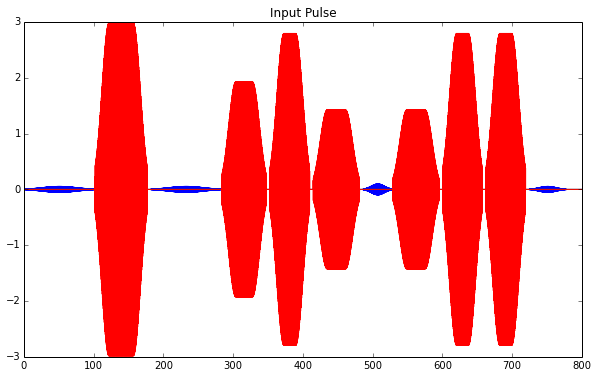

10.0%. Run time: 109.19s. Est. time left: 00:00:16:22
20.0%. Run time: 224.88s. Est. time left: 00:00:14:59
30.0%. Run time: 329.46s. Est. time left: 00:00:12:48
40.0%. Run time: 435.32s. Est. time left: 00:00:10:52
50.0%. Run time: 546.69s. Est. time left: 00:00:09:06
60.0%. Run time: 654.51s. Est. time left: 00:00:07:16
70.0%. Run time: 757.31s. Est. time left: 00:00:05:24
80.0%. Run time: 870.94s. Est. time left: 00:00:03:37
90.0%. Run time: 984.52s. Est. time left: 00:00:01:49
Total run time: 1083.02s
0.89268370752
Phase: -2.44346095279


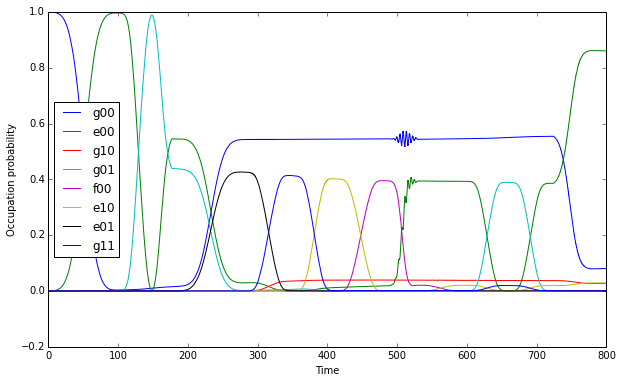

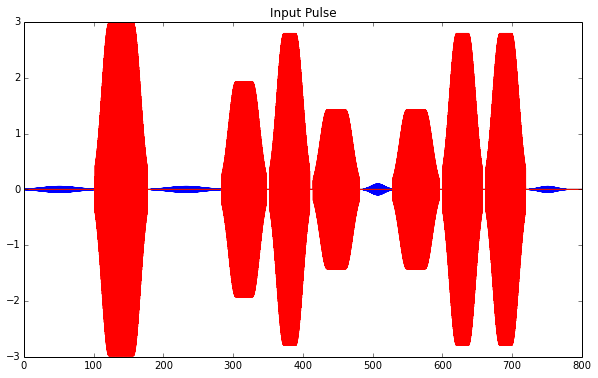

10.0%. Run time: 110.84s. Est. time left: 00:00:16:37
20.0%. Run time: 232.53s. Est. time left: 00:00:15:30
30.0%. Run time: 336.47s. Est. time left: 00:00:13:05
40.0%. Run time: 443.01s. Est. time left: 00:00:11:04
50.0%. Run time: 554.90s. Est. time left: 00:00:09:14
60.0%. Run time: 662.89s. Est. time left: 00:00:07:21
70.0%. Run time: 766.20s. Est. time left: 00:00:05:28
80.0%. Run time: 879.43s. Est. time left: 00:00:03:39
90.0%. Run time: 993.94s. Est. time left: 00:00:01:50
Total run time: 1097.06s
0.66565689847
Phase: -1.74532925199


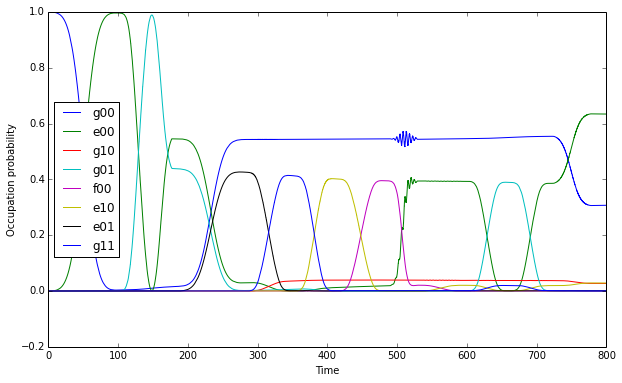

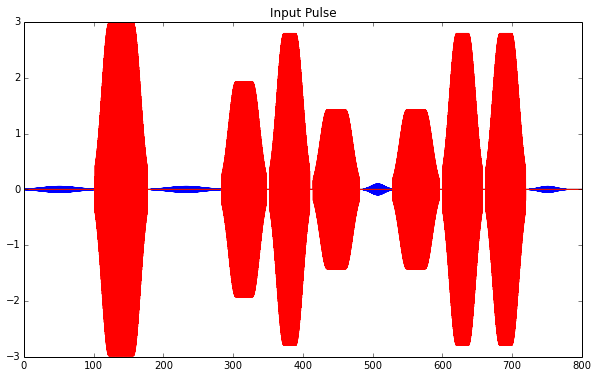

10.0%. Run time: 109.97s. Est. time left: 00:00:16:29
20.0%. Run time: 225.63s. Est. time left: 00:00:15:02
30.0%. Run time: 329.48s. Est. time left: 00:00:12:48
40.0%. Run time: 435.64s. Est. time left: 00:00:10:53
50.0%. Run time: 546.57s. Est. time left: 00:00:09:06
60.0%. Run time: 654.21s. Est. time left: 00:00:07:16
70.0%. Run time: 757.83s. Est. time left: 00:00:05:24
80.0%. Run time: 870.73s. Est. time left: 00:00:03:37
90.0%. Run time: 986.34s. Est. time left: 00:00:01:49
Total run time: 1089.89s
0.357641201481
Phase: -1.0471975512


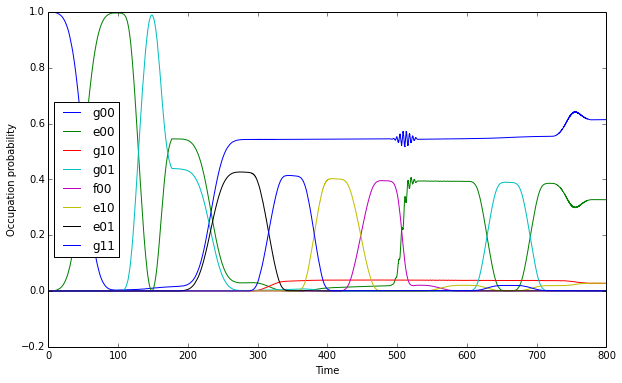

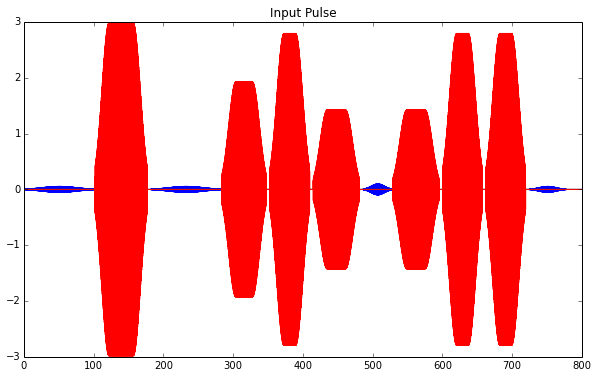

10.0%. Run time: 109.97s. Est. time left: 00:00:16:29
20.0%. Run time: 225.42s. Est. time left: 00:00:15:01
30.0%. Run time: 328.74s. Est. time left: 00:00:12:47
40.0%. Run time: 440.26s. Est. time left: 00:00:11:00
50.0%. Run time: 552.60s. Est. time left: 00:00:09:12
60.0%. Run time: 660.56s. Est. time left: 00:00:07:20
70.0%. Run time: 764.28s. Est. time left: 00:00:05:27
80.0%. Run time: 877.90s. Est. time left: 00:00:03:39
90.0%. Run time: 992.37s. Est. time left: 00:00:01:50
Total run time: 1070.76s
0.116969924783
Phase: -0.349065850399


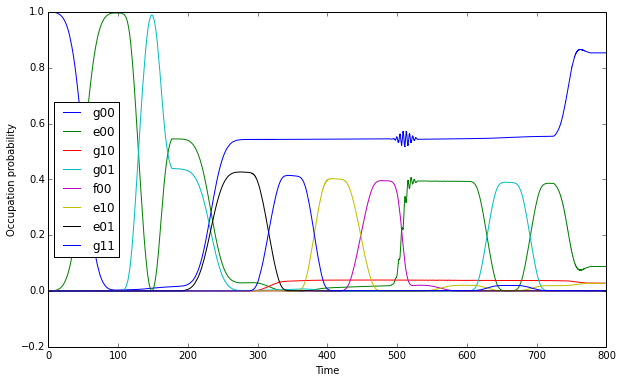

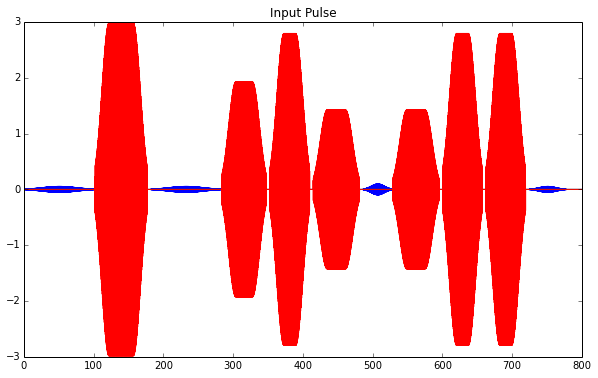

10.0%. Run time: 110.29s. Est. time left: 00:00:16:32
20.0%. Run time: 226.96s. Est. time left: 00:00:15:07
30.0%. Run time: 330.82s. Est. time left: 00:00:12:51
40.0%. Run time: 438.23s. Est. time left: 00:00:10:57
50.0%. Run time: 554.10s. Est. time left: 00:00:09:14
60.0%. Run time: 664.21s. Est. time left: 00:00:07:22
70.0%. Run time: 768.26s. Est. time left: 00:00:05:29
80.0%. Run time: 882.39s. Est. time left: 00:00:03:40
90.0%. Run time: 995.43s. Est. time left: 00:00:01:50
Total run time: 1070.59s
0.062072520615
Phase: 0.349065850399


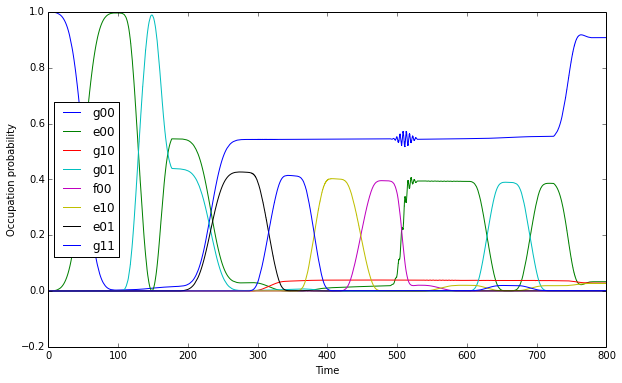

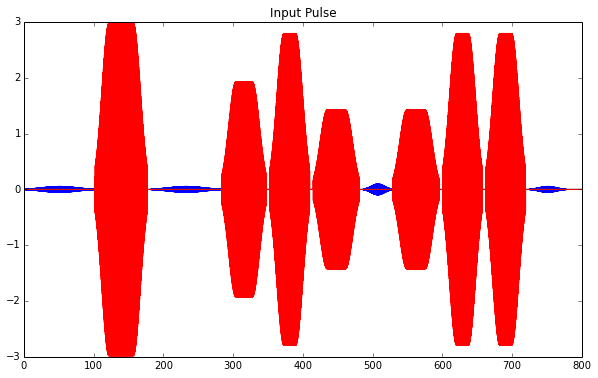

10.0%. Run time: 110.81s. Est. time left: 00:00:16:37
20.0%. Run time: 227.47s. Est. time left: 00:00:15:09
30.0%. Run time: 331.85s. Est. time left: 00:00:12:54
40.0%. Run time: 438.74s. Est. time left: 00:00:10:58
50.0%. Run time: 551.19s. Est. time left: 00:00:09:11
60.0%. Run time: 659.82s. Est. time left: 00:00:07:19
70.0%. Run time: 764.15s. Est. time left: 00:00:05:27
80.0%. Run time: 878.46s. Est. time left: 00:00:03:39
90.0%. Run time: 991.78s. Est. time left: 00:00:01:50
Total run time: 1073.82s
0.223460623677
Phase: 1.0471975512


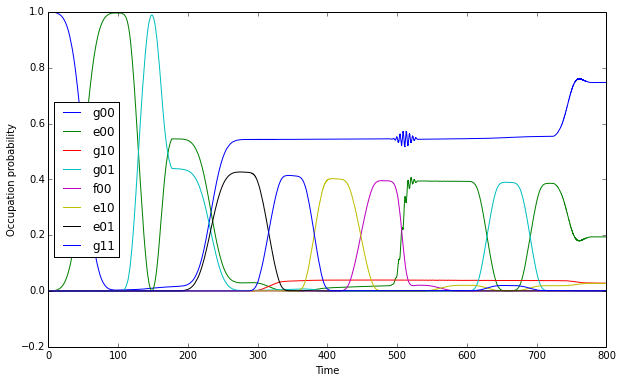

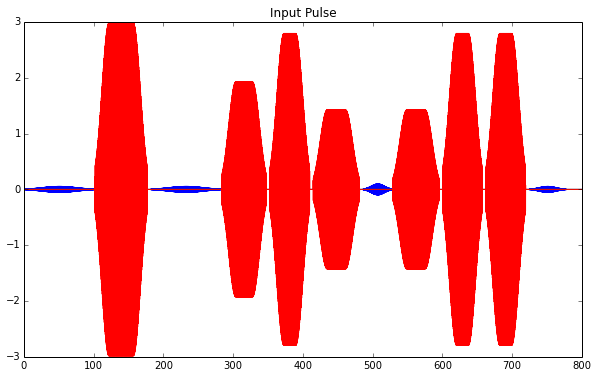

10.0%. Run time: 109.45s. Est. time left: 00:00:16:25
20.0%. Run time: 225.05s. Est. time left: 00:00:15:00
30.0%. Run time: 328.57s. Est. time left: 00:00:12:46
40.0%. Run time: 434.48s. Est. time left: 00:00:10:51
50.0%. Run time: 545.67s. Est. time left: 00:00:09:05
60.0%. Run time: 653.04s. Est. time left: 00:00:07:15
70.0%. Run time: 756.14s. Est. time left: 00:00:05:24
80.0%. Run time: 869.72s. Est. time left: 00:00:03:37
90.0%. Run time: 983.71s. Est. time left: 00:00:01:49
Total run time: 1087.05s
0.512763456921
Phase: 1.74532925199


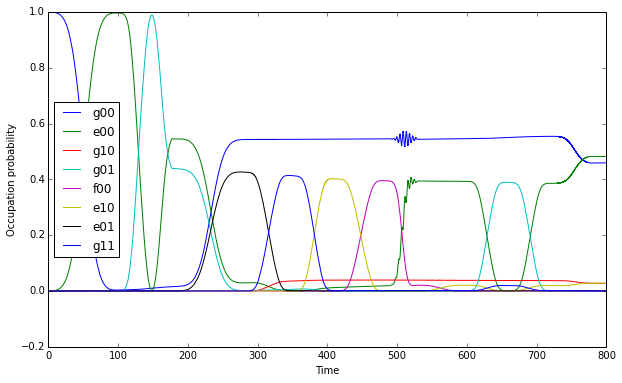

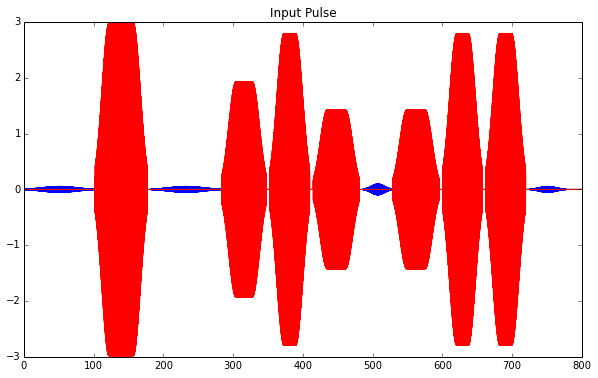

10.0%. Run time: 109.97s. Est. time left: 00:00:16:29
20.0%. Run time: 225.84s. Est. time left: 00:00:15:03
30.0%. Run time: 329.50s. Est. time left: 00:00:12:48
40.0%. Run time: 435.17s. Est. time left: 00:00:10:52
50.0%. Run time: 546.66s. Est. time left: 00:00:09:06
60.0%. Run time: 654.90s. Est. time left: 00:00:07:16
70.0%. Run time: 758.35s. Est. time left: 00:00:05:25
80.0%. Run time: 871.44s. Est. time left: 00:00:03:37
90.0%. Run time: 982.92s. Est. time left: 00:00:01:49
Total run time: 1080.38s
0.794043712589
Phase: 2.44346095279


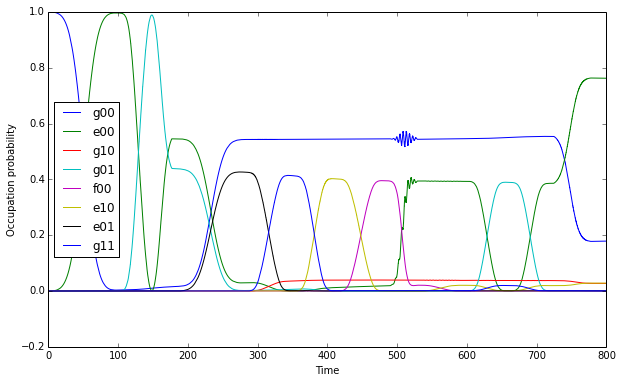

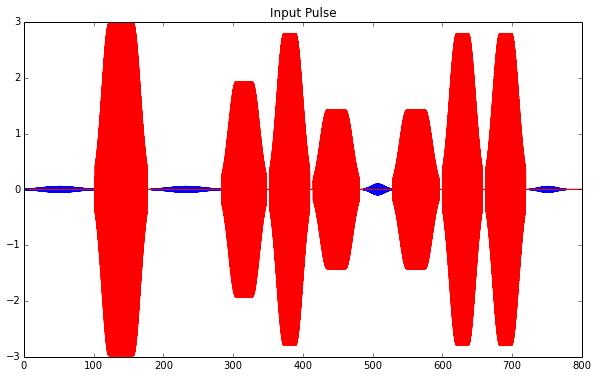

10.0%. Run time: 114.63s. Est. time left: 00:00:17:11
20.0%. Run time: 231.10s. Est. time left: 00:00:15:24
30.0%. Run time: 335.35s. Est. time left: 00:00:13:02
40.0%. Run time: 441.78s. Est. time left: 00:00:11:02
50.0%. Run time: 553.25s. Est. time left: 00:00:09:13
60.0%. Run time: 660.92s. Est. time left: 00:00:07:20
70.0%. Run time: 764.29s. Est. time left: 00:00:05:27
80.0%. Run time: 878.13s. Est. time left: 00:00:03:39
90.0%. Run time: 991.19s. Est. time left: 00:00:01:50
Total run time: 1087.01s
0.942171703232
Phase: 3.14159265359


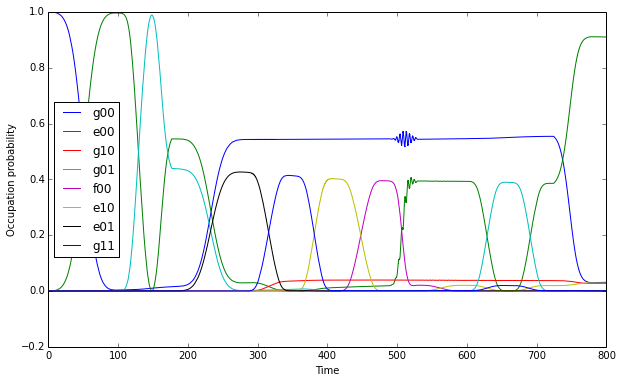

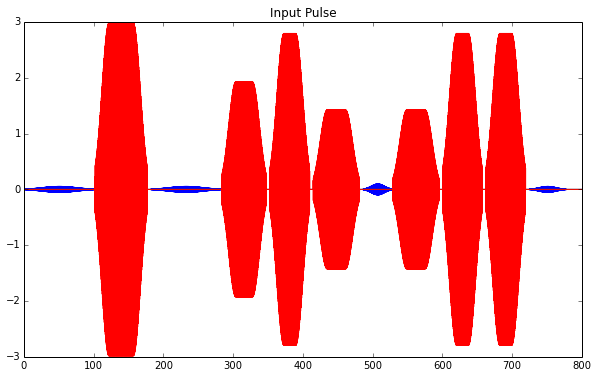

10.0%. Run time: 110.44s. Est. time left: 00:00:16:33
20.0%. Run time: 226.87s. Est. time left: 00:00:15:07
30.0%. Run time: 330.96s. Est. time left: 00:00:12:52
40.0%. Run time: 437.12s. Est. time left: 00:00:10:55
50.0%. Run time: 548.58s. Est. time left: 00:00:09:08
60.0%. Run time: 656.75s. Est. time left: 00:00:07:17
70.0%. Run time: 760.20s. Est. time left: 00:00:05:25
80.0%. Run time: 874.36s. Est. time left: 00:00:03:38
90.0%. Run time: 988.12s. Est. time left: 00:00:01:49
Total run time: 1086.93s
0.892683034554


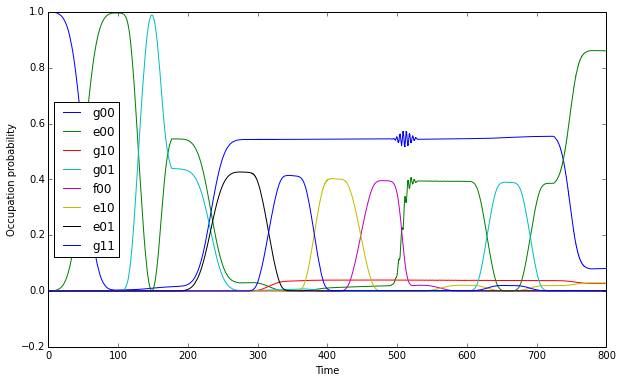

In [16]:
def GHZ_XX_phase_sweep():
    sys_para = SystemParameters()
    sys_para.update_total_time(800)
    
    tomo_measure_e = []
    
    def prepare_GHZ(sys_para):
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = initiate_pulse(sys_para)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_3pi2_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    for phase in np.linspace(-np.pi,np.pi,10):
        print "Phase: " + str(phase)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = prepare_GHZ(sys_para)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CX(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse, phase = phase)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse,phase = np.pi/2)

        measure_e = run_experiment(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time = time, run=True)
        tomo_measure_e.append(measure_e)
        
        np.save("./data/ghz_xx_phase_sweep", np.array(tomo_measure_e))
        
GHZ_XX_phase_sweep()

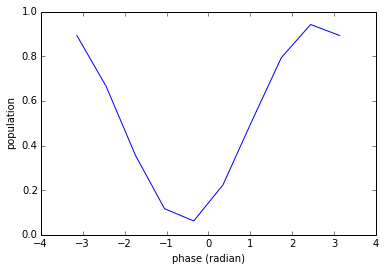

In [21]:
ghz_xx_phase_sweep = np.load("./data/ghz_xx_phase_sweep/ghz_xx_phase_sweep.npy")

plt.plot(np.linspace(-np.pi,np.pi,10),ghz_xx_phase_sweep)
plt.ylabel("population")
plt.xlabel("phase (radian)")

### < XY> phase sweep

Phase: -3.14159265359


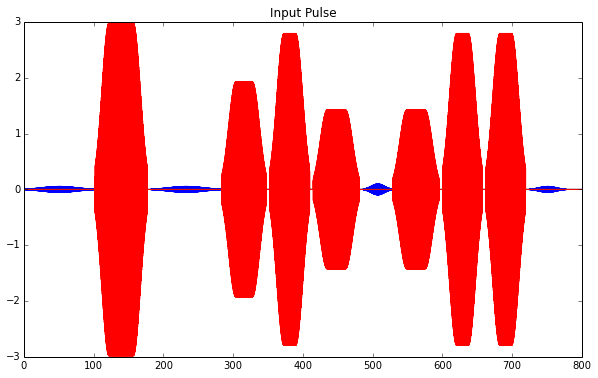

10.0%. Run time: 110.92s. Est. time left: 00:00:16:38
20.0%. Run time: 228.42s. Est. time left: 00:00:15:13
30.0%. Run time: 332.97s. Est. time left: 00:00:12:56
40.0%. Run time: 440.14s. Est. time left: 00:00:11:00
50.0%. Run time: 552.73s. Est. time left: 00:00:09:12
60.0%. Run time: 661.99s. Est. time left: 00:00:07:21
70.0%. Run time: 767.86s. Est. time left: 00:00:05:29
80.0%. Run time: 879.89s. Est. time left: 00:00:03:39
90.0%. Run time: 995.46s. Est. time left: 00:00:01:50
Total run time: 1078.71s
0.284974356461
Phase: -2.44346095279


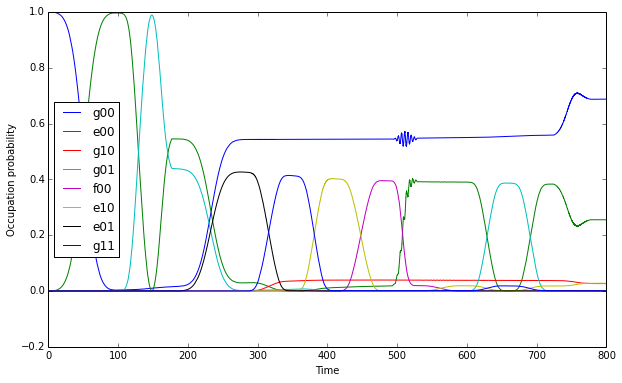

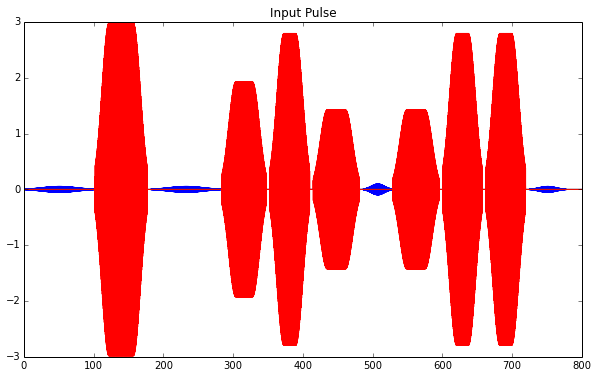

10.0%. Run time: 110.61s. Est. time left: 00:00:16:35
20.0%. Run time: 227.46s. Est. time left: 00:00:15:09
30.0%. Run time: 332.47s. Est. time left: 00:00:12:55
40.0%. Run time: 439.48s. Est. time left: 00:00:10:59
50.0%. Run time: 560.84s. Est. time left: 00:00:09:20
60.0%. Run time: 669.93s. Est. time left: 00:00:07:26
70.0%. Run time: 775.63s. Est. time left: 00:00:05:32
80.0%. Run time: 887.71s. Est. time left: 00:00:03:41
90.0%. Run time: 1002.52s. Est. time left: 00:00:01:51
Total run time: 1106.87s
0.0859766140654
Phase: -1.74532925199


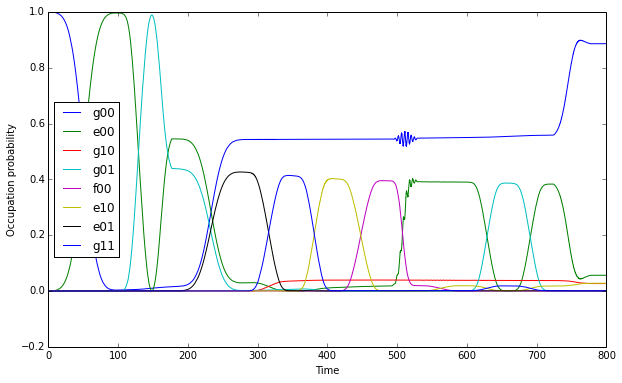

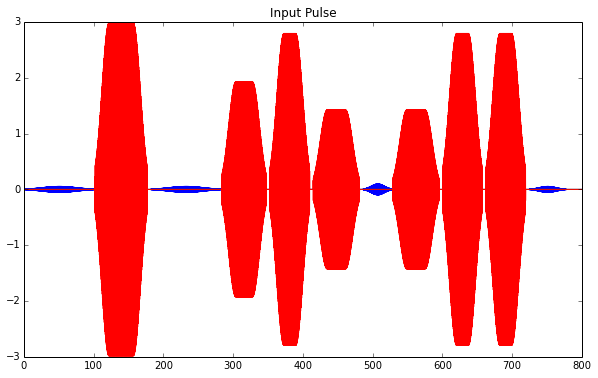

10.0%. Run time: 110.84s. Est. time left: 00:00:16:37
20.0%. Run time: 227.43s. Est. time left: 00:00:15:09
30.0%. Run time: 331.79s. Est. time left: 00:00:12:54
40.0%. Run time: 439.26s. Est. time left: 00:00:10:58
50.0%. Run time: 552.09s. Est. time left: 00:00:09:12
60.0%. Run time: 660.67s. Est. time left: 00:00:07:20
70.0%. Run time: 766.06s. Est. time left: 00:00:05:28
80.0%. Run time: 878.02s. Est. time left: 00:00:03:39
90.0%. Run time: 993.46s. Est. time left: 00:00:01:50
Total run time: 1097.24s
0.0806472799934
Phase: -1.0471975512


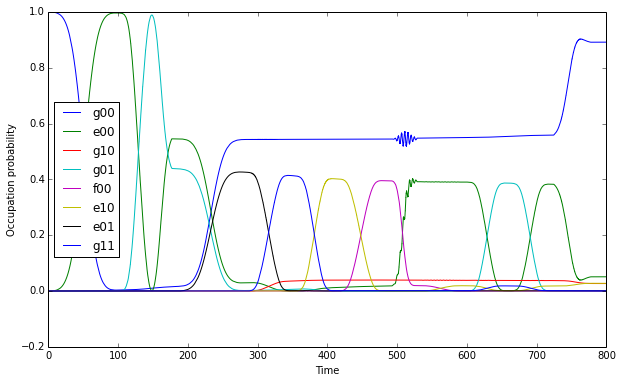

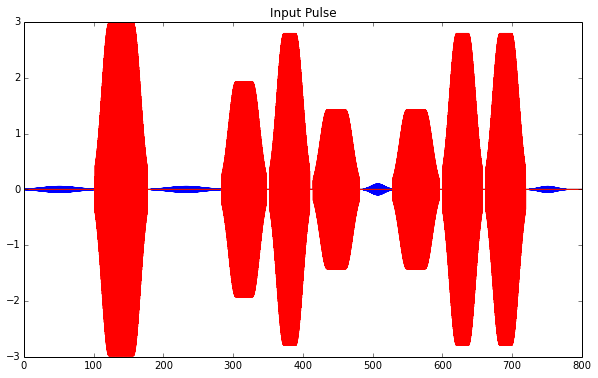

10.0%. Run time: 111.21s. Est. time left: 00:00:16:40
20.0%. Run time: 229.10s. Est. time left: 00:00:15:16
30.0%. Run time: 334.56s. Est. time left: 00:00:13:00
40.0%. Run time: 441.92s. Est. time left: 00:00:11:02
50.0%. Run time: 554.16s. Est. time left: 00:00:09:14
60.0%. Run time: 663.21s. Est. time left: 00:00:07:22
70.0%. Run time: 769.15s. Est. time left: 00:00:05:29
80.0%. Run time: 881.42s. Est. time left: 00:00:03:40
90.0%. Run time: 997.25s. Est. time left: 00:00:01:50
Total run time: 1079.34s
0.2771091957
Phase: -0.349065850399


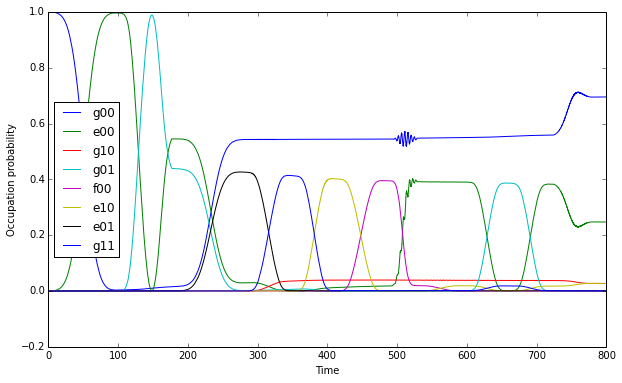

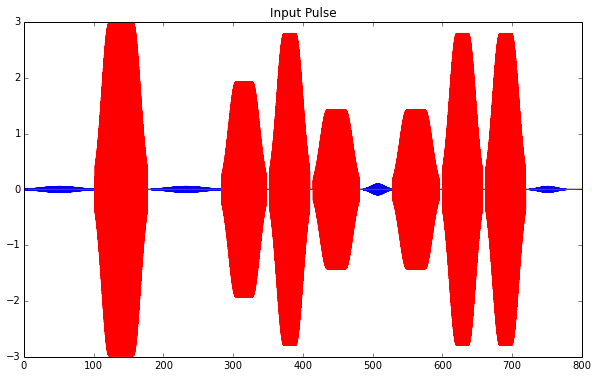

10.0%. Run time: 110.67s. Est. time left: 00:00:16:35
20.0%. Run time: 227.09s. Est. time left: 00:00:15:08
30.0%. Run time: 331.26s. Est. time left: 00:00:12:52
40.0%. Run time: 438.64s. Est. time left: 00:00:10:57
50.0%. Run time: 550.86s. Est. time left: 00:00:09:10
60.0%. Run time: 659.45s. Est. time left: 00:00:07:19
70.0%. Run time: 764.95s. Est. time left: 00:00:05:27
80.0%. Run time: 876.70s. Est. time left: 00:00:03:39
90.0%. Run time: 990.61s. Est. time left: 00:00:01:50
Total run time: 1090.71s
0.58438063927
Phase: 0.349065850399


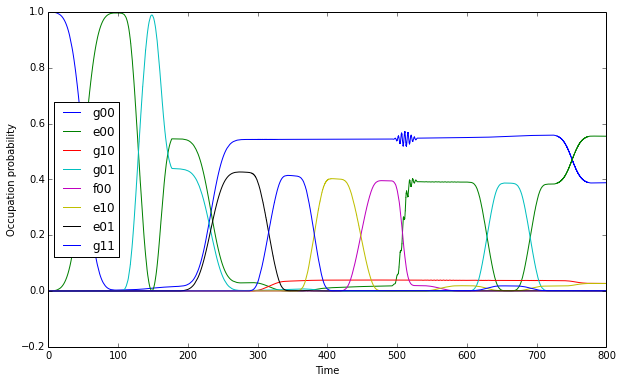

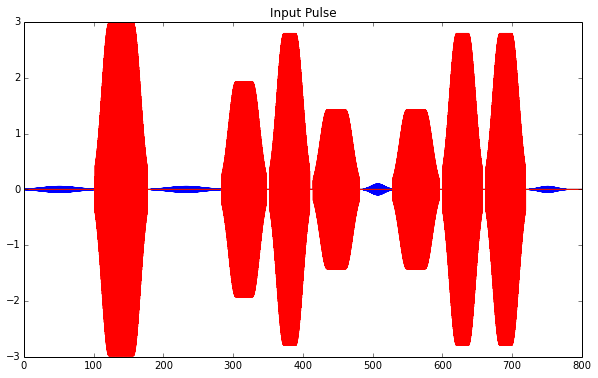

10.0%. Run time: 112.63s. Est. time left: 00:00:16:53
20.0%. Run time: 229.13s. Est. time left: 00:00:15:16
30.0%. Run time: 333.66s. Est. time left: 00:00:12:58
40.0%. Run time: 440.22s. Est. time left: 00:00:11:00
50.0%. Run time: 552.23s. Est. time left: 00:00:09:12
60.0%. Run time: 661.09s. Est. time left: 00:00:07:20
70.0%. Run time: 766.65s. Est. time left: 00:00:05:28
80.0%. Run time: 878.37s. Est. time left: 00:00:03:39
90.0%. Run time: 991.73s. Est. time left: 00:00:01:50
Total run time: 1089.64s
0.849585969678
Phase: 1.0471975512


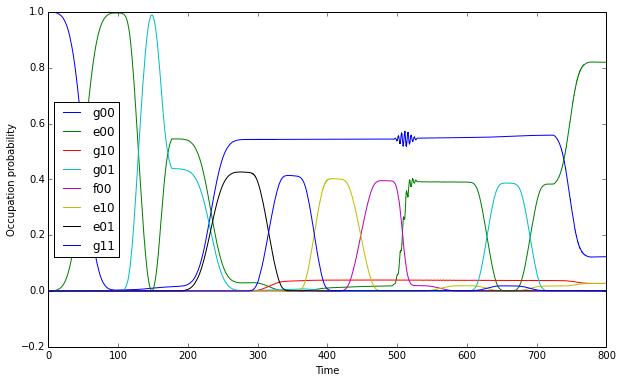

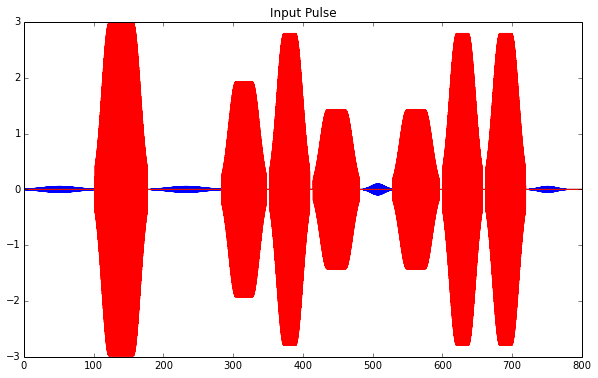

10.0%. Run time: 110.74s. Est. time left: 00:00:16:36
20.0%. Run time: 228.12s. Est. time left: 00:00:15:12
30.0%. Run time: 332.43s. Est. time left: 00:00:12:55
40.0%. Run time: 439.56s. Est. time left: 00:00:10:59
50.0%. Run time: 551.69s. Est. time left: 00:00:09:11
60.0%. Run time: 660.63s. Est. time left: 00:00:07:20
70.0%. Run time: 768.15s. Est. time left: 00:00:05:29
80.0%. Run time: 880.32s. Est. time left: 00:00:03:40
90.0%. Run time: 993.69s. Est. time left: 00:00:01:50
Total run time: 1096.94s
0.948176844108
Phase: 1.74532925199


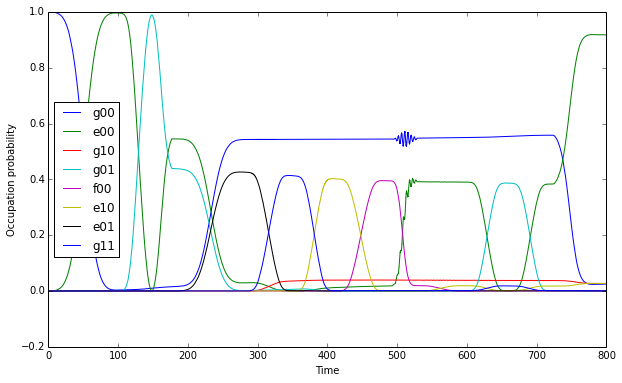

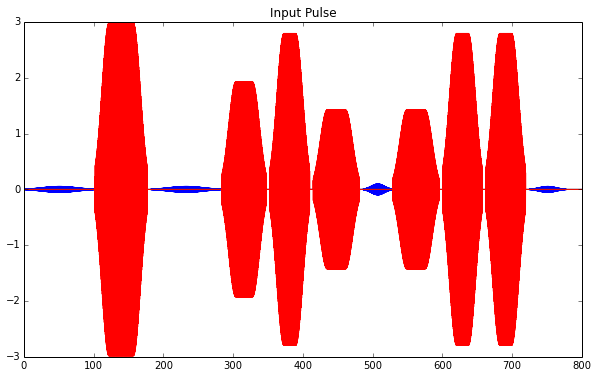

10.0%. Run time: 110.75s. Est. time left: 00:00:16:36
20.0%. Run time: 227.78s. Est. time left: 00:00:15:11
30.0%. Run time: 332.22s. Est. time left: 00:00:12:55
40.0%. Run time: 439.05s. Est. time left: 00:00:10:58
50.0%. Run time: 552.02s. Est. time left: 00:00:09:12
60.0%. Run time: 660.85s. Est. time left: 00:00:07:20
70.0%. Run time: 766.13s. Est. time left: 00:00:05:28
80.0%. Run time: 877.62s. Est. time left: 00:00:03:39
90.0%. Run time: 990.00s. Est. time left: 00:00:01:49
Total run time: 1088.40s
0.839936170168
Phase: 2.44346095279


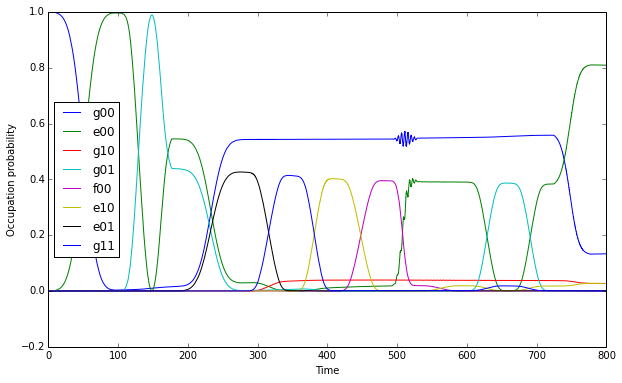

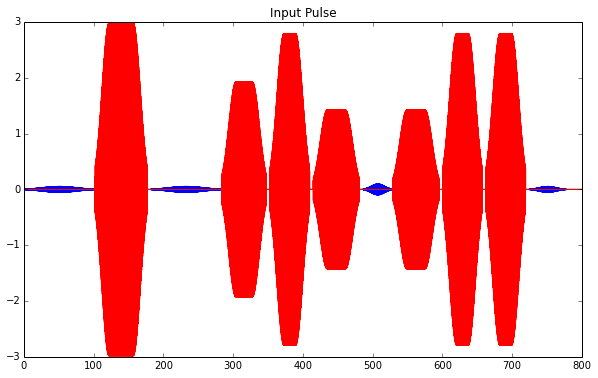

10.0%. Run time: 110.49s. Est. time left: 00:00:16:34
20.0%. Run time: 227.63s. Est. time left: 00:00:15:10
30.0%. Run time: 333.17s. Est. time left: 00:00:12:57
40.0%. Run time: 446.39s. Est. time left: 00:00:11:09
50.0%. Run time: 558.09s. Est. time left: 00:00:09:18
60.0%. Run time: 666.85s. Est. time left: 00:00:07:24
70.0%. Run time: 772.25s. Est. time left: 00:00:05:30
80.0%. Run time: 884.41s. Est. time left: 00:00:03:41
90.0%. Run time: 999.44s. Est. time left: 00:00:01:51
Total run time: 1094.15s
0.580063024607
Phase: 3.14159265359


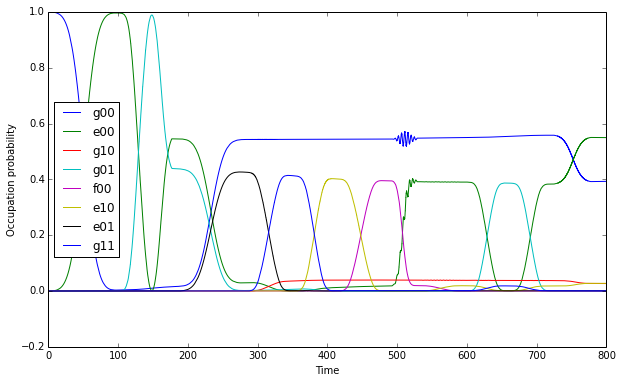

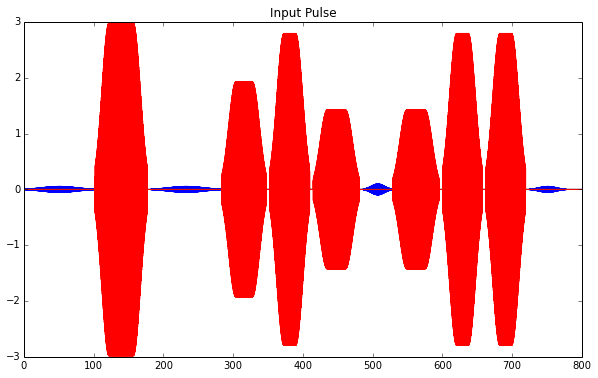

10.0%. Run time: 112.20s. Est. time left: 00:00:16:49
20.0%. Run time: 228.87s. Est. time left: 00:00:15:15
30.0%. Run time: 333.61s. Est. time left: 00:00:12:58
40.0%. Run time: 440.05s. Est. time left: 00:00:11:00
50.0%. Run time: 551.90s. Est. time left: 00:00:09:11
60.0%. Run time: 660.43s. Est. time left: 00:00:07:20
70.0%. Run time: 765.51s. Est. time left: 00:00:05:28
80.0%. Run time: 877.33s. Est. time left: 00:00:03:39
90.0%. Run time: 994.71s. Est. time left: 00:00:01:50
Total run time: 1081.34s
0.284973918958


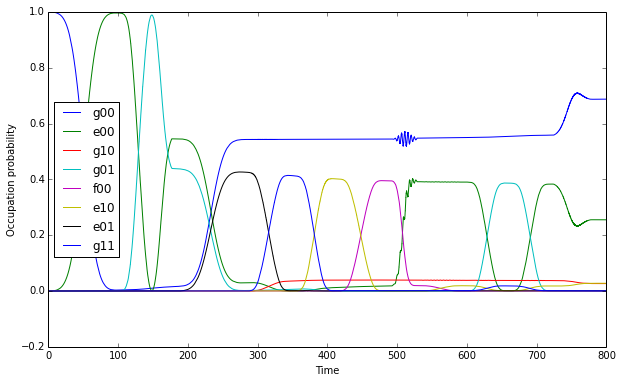

In [22]:
def GHZ_XY_phase_sweep():
    sys_para = SystemParameters()
    sys_para.update_total_time(800)
    
    tomo_measure_e = []
    
    def prepare_GHZ(sys_para):
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = initiate_pulse(sys_para)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_3pi2_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    for phase in np.linspace(-np.pi,np.pi,10):
        print "Phase: " + str(phase)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = prepare_GHZ(sys_para) 
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CY(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse, phase = phase)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse,phase = np.pi/2)

        measure_e = run_experiment(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time = time, run=True)
        tomo_measure_e.append(measure_e)
        
        np.save("./data/ghz_xy_phase_sweep", np.array(tomo_measure_e))
        
GHZ_XY_phase_sweep()

2.56669516063


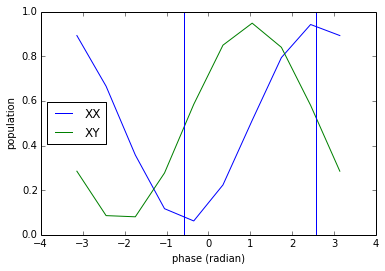

In [82]:
ghz_xx_phase_sweep = np.load("./data/ghz_xx_phase_sweep/ghz_xx_phase_sweep.npy")
plt.plot(np.linspace(-np.pi,np.pi,10),ghz_xx_phase_sweep,label='XX')

ghz_xy_phase_sweep = np.load("./data/ghz_xy_phase_sweep/ghz_xy_phase_sweep.npy")
plt.plot(np.linspace(-np.pi,np.pi,10),ghz_xy_phase_sweep,label="XY")

minimum_phase = (3.14159265359-2.44346095279)*(4.67652-1)-np.pi
plt.axvline(minimum_phase)

maximum_phase = (3.14159265359-2.44346095279)*(4.67652-1)
plt.axvline(maximum_phase)

plt.ylabel("population")
plt.xlabel("phase (radian)")
plt.ylabel("population")
plt.xlabel("phase (radian)")
plt.legend(loc='0')

print maximum_phase

In [83]:
def tomo_pulse(sys_para,tomo_index,Hx_pulse, Hy_pulse, Hz_pulse, time, final_offset_not):
    
    if tomo_index == 0:
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse,phase = np.pi/2)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 1:
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 2:
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 3:
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse,phase = np.pi/2)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 4:
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CX(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse,phase = final_offset_not)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse,phase = np.pi/2)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 5:
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CY(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse, phase = final_offset_not)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse,phase = np.pi/2)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 6:
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CZ(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse,phase = np.pi/2)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 7:
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 8:
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CX(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse, phase = final_offset_not)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 9:
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CY(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse, phase = final_offset_not)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 10:
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CZ(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 11:
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 12:
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CZ(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse,phase = np.pi/2)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 13:
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CZ(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    if tomo_index == 14:
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CX(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse, phase = final_offset_not)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
        
            

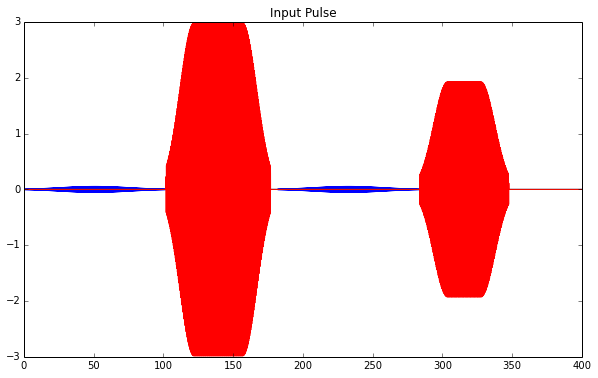

None


In [69]:
def GHZ():
    sys_para = SystemParameters()
    sys_para.update_total_time(400)
    
    def prepare_GHZ(sys_para):
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = initiate_pulse(sys_para)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_3pi2_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    [Hx_pulse,Hy_pulse,Hz_pulse,time] = prepare_GHZ(sys_para)

    measure_e = run_experiment(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time = time, run=False)
    print measure_e
    
GHZ()

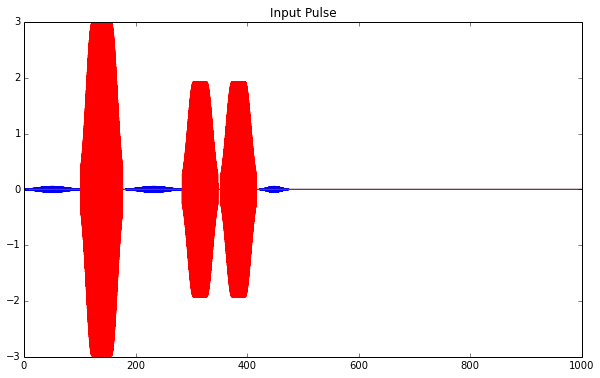

10.0%. Run time: 141.44s. Est. time left: 00:00:21:12
20.0%. Run time: 277.64s. Est. time left: 00:00:18:30
30.0%. Run time: 409.76s. Est. time left: 00:00:15:56
40.0%. Run time: 540.38s. Est. time left: 00:00:13:30
50.0%. Run time: 662.30s. Est. time left: 00:00:11:02
60.0%. Run time: 788.02s. Est. time left: 00:00:08:45
70.0%. Run time: 914.09s. Est. time left: 00:00:06:31
80.0%. Run time: 1039.87s. Est. time left: 00:00:04:19
90.0%. Run time: 1165.48s. Est. time left: 00:00:02:09
Total run time: 1291.48s
0.532773441722


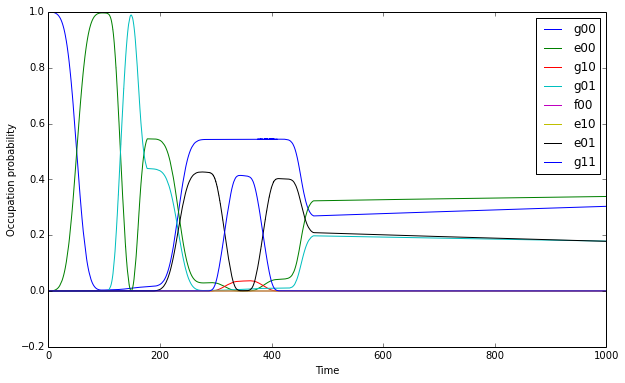

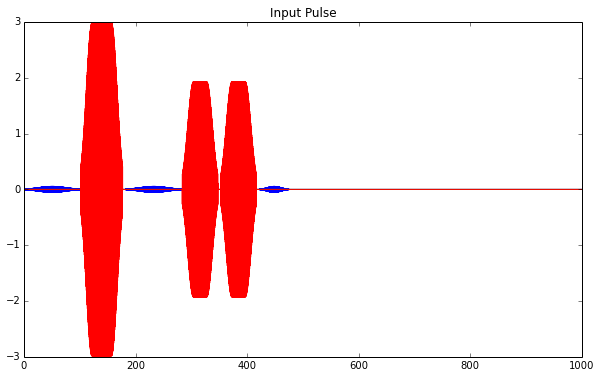

10.0%. Run time: 140.28s. Est. time left: 00:00:21:02
20.0%. Run time: 276.70s. Est. time left: 00:00:18:26
30.0%. Run time: 408.53s. Est. time left: 00:00:15:53
40.0%. Run time: 547.19s. Est. time left: 00:00:13:40
50.0%. Run time: 671.31s. Est. time left: 00:00:11:11
60.0%. Run time: 797.58s. Est. time left: 00:00:08:51
70.0%. Run time: 924.00s. Est. time left: 00:00:06:35
80.0%. Run time: 1050.50s. Est. time left: 00:00:04:22
90.0%. Run time: 1176.08s. Est. time left: 00:00:02:10
Total run time: 1302.14s
0.510284038238


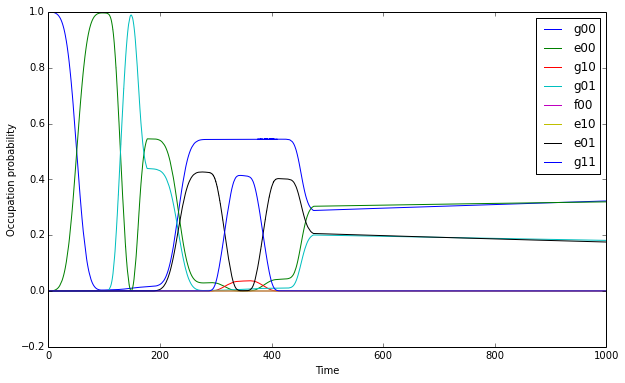

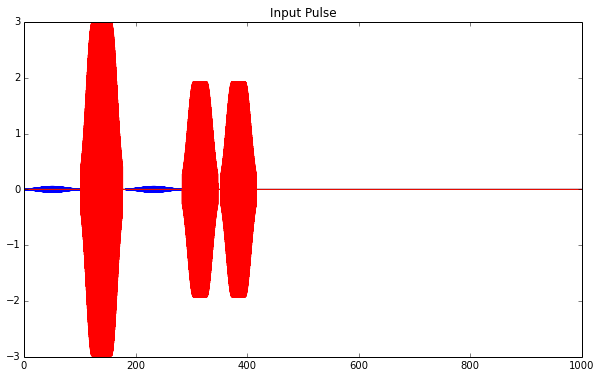

10.0%. Run time: 141.32s. Est. time left: 00:00:21:11
20.0%. Run time: 278.84s. Est. time left: 00:00:18:35
30.0%. Run time: 411.94s. Est. time left: 00:00:16:01
40.0%. Run time: 543.52s. Est. time left: 00:00:13:35
50.0%. Run time: 637.04s. Est. time left: 00:00:10:37
60.0%. Run time: 726.37s. Est. time left: 00:00:08:04
70.0%. Run time: 815.25s. Est. time left: 00:00:05:49
80.0%. Run time: 904.42s. Est. time left: 00:00:03:46
90.0%. Run time: 993.31s. Est. time left: 00:00:01:50
Total run time: 1082.49s
0.4447845315


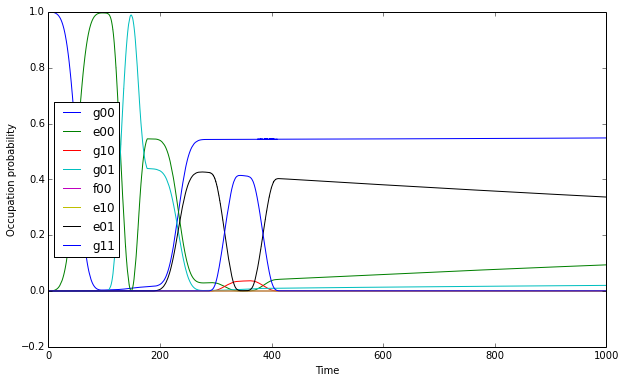

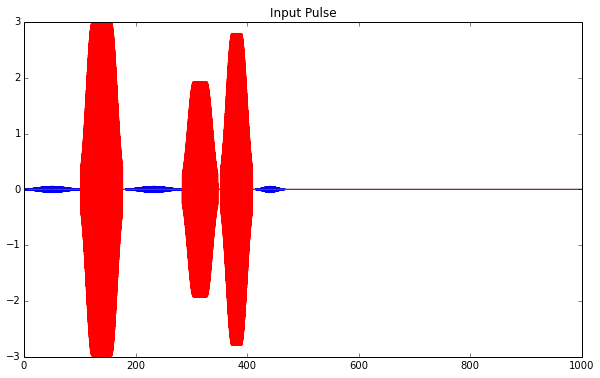

10.0%. Run time: 149.23s. Est. time left: 00:00:22:23
20.0%. Run time: 286.20s. Est. time left: 00:00:19:04
30.0%. Run time: 418.81s. Est. time left: 00:00:16:17
40.0%. Run time: 560.33s. Est. time left: 00:00:14:00
50.0%. Run time: 676.53s. Est. time left: 00:00:11:16
60.0%. Run time: 757.82s. Est. time left: 00:00:08:25
70.0%. Run time: 838.13s. Est. time left: 00:00:05:59
80.0%. Run time: 919.75s. Est. time left: 00:00:03:49
90.0%. Run time: 1000.81s. Est. time left: 00:00:01:51
Total run time: 1080.68s
0.46877339721


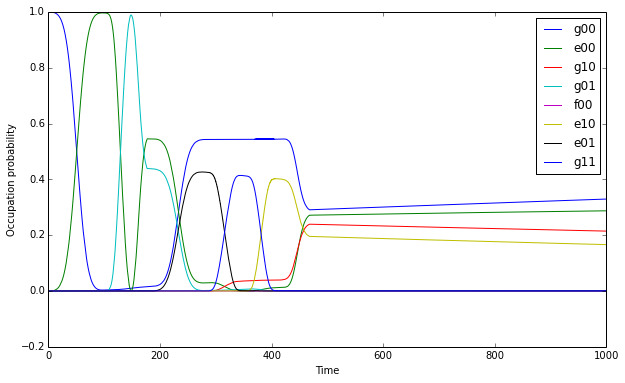

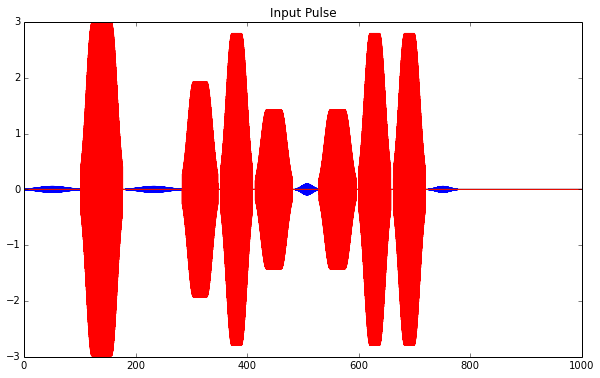

10.0%. Run time: 140.66s. Est. time left: 00:00:21:05
20.0%. Run time: 276.90s. Est. time left: 00:00:18:27
30.0%. Run time: 409.46s. Est. time left: 00:00:15:55
40.0%. Run time: 549.88s. Est. time left: 00:00:13:44
50.0%. Run time: 683.85s. Est. time left: 00:00:11:23
60.0%. Run time: 814.91s. Est. time left: 00:00:09:03
70.0%. Run time: 966.76s. Est. time left: 00:00:06:54
80.0%. Run time: 1104.67s. Est. time left: 00:00:04:36
90.0%. Run time: 1233.84s. Est. time left: 00:00:02:17
Total run time: 1361.78s
0.948959838751


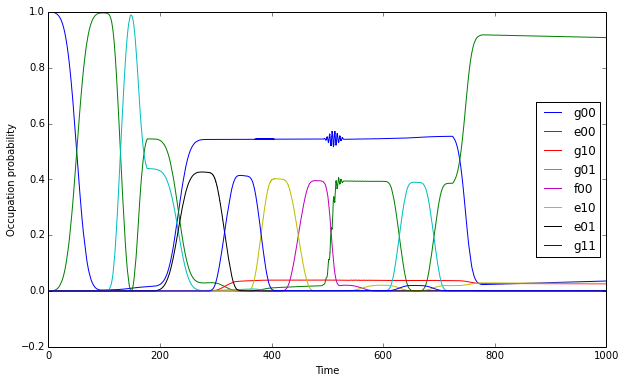

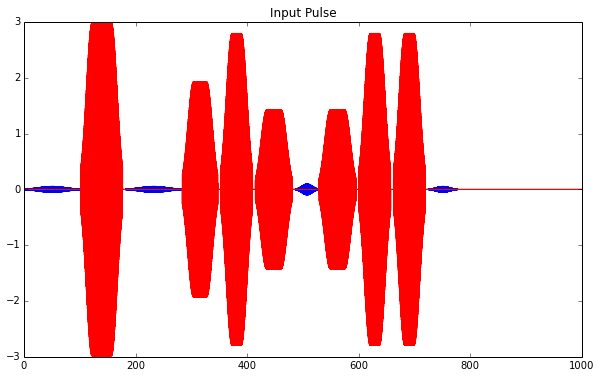

10.0%. Run time: 141.02s. Est. time left: 00:00:21:09
20.0%. Run time: 277.87s. Est. time left: 00:00:18:31
30.0%. Run time: 410.56s. Est. time left: 00:00:15:57
40.0%. Run time: 550.86s. Est. time left: 00:00:13:46
50.0%. Run time: 686.61s. Est. time left: 00:00:11:26
60.0%. Run time: 817.40s. Est. time left: 00:00:09:04
70.0%. Run time: 963.55s. Est. time left: 00:00:06:52
80.0%. Run time: 1093.95s. Est. time left: 00:00:04:33
90.0%. Run time: 1221.61s. Est. time left: 00:00:02:15
Total run time: 1349.51s
0.495889616725


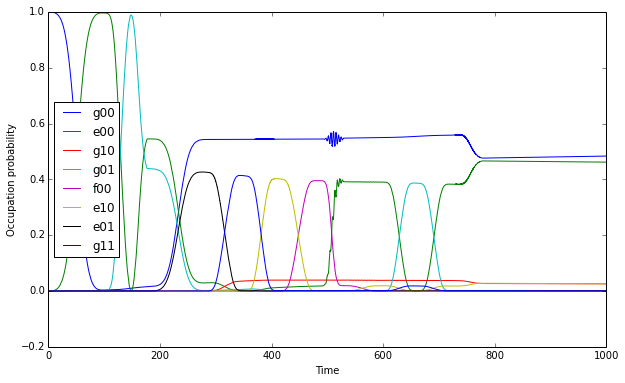

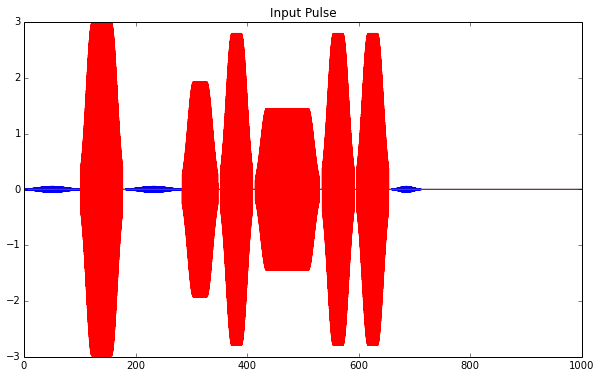

10.0%. Run time: 141.39s. Est. time left: 00:00:21:12
20.0%. Run time: 277.92s. Est. time left: 00:00:18:31
30.0%. Run time: 410.25s. Est. time left: 00:00:15:57
40.0%. Run time: 550.65s. Est. time left: 00:00:13:45
50.0%. Run time: 690.97s. Est. time left: 00:00:11:30
60.0%. Run time: 833.88s. Est. time left: 00:00:09:15
70.0%. Run time: 971.08s. Est. time left: 00:00:06:56
80.0%. Run time: 1097.55s. Est. time left: 00:00:04:34
90.0%. Run time: 1223.25s. Est. time left: 00:00:02:15
Total run time: 1349.00s
0.504790350105


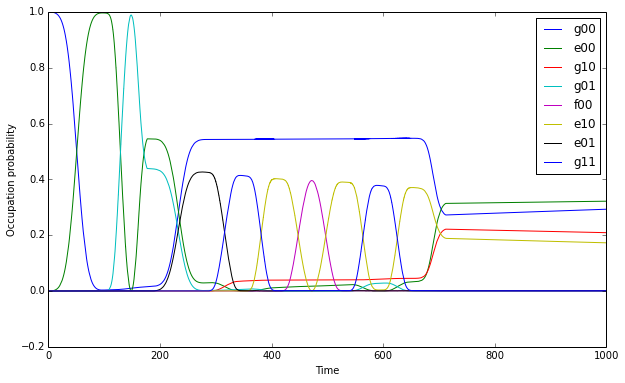

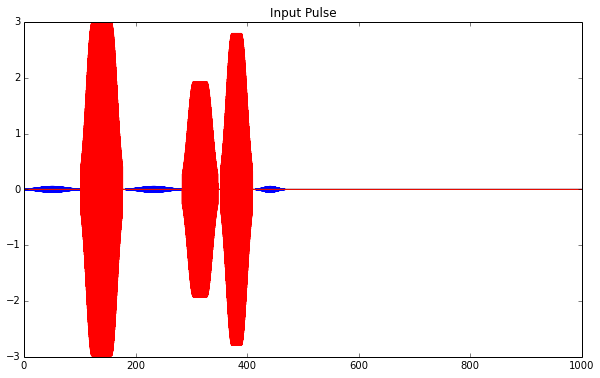

10.0%. Run time: 139.93s. Est. time left: 00:00:20:59
20.0%. Run time: 277.62s. Est. time left: 00:00:18:30
30.0%. Run time: 413.94s. Est. time left: 00:00:16:05
40.0%. Run time: 555.43s. Est. time left: 00:00:13:53
50.0%. Run time: 693.82s. Est. time left: 00:00:11:33
60.0%. Run time: 831.10s. Est. time left: 00:00:09:14
70.0%. Run time: 968.38s. Est. time left: 00:00:06:55
80.0%. Run time: 1106.18s. Est. time left: 00:00:04:36
90.0%. Run time: 1244.35s. Est. time left: 00:00:02:18
Total run time: 1381.64s
0.502156554782


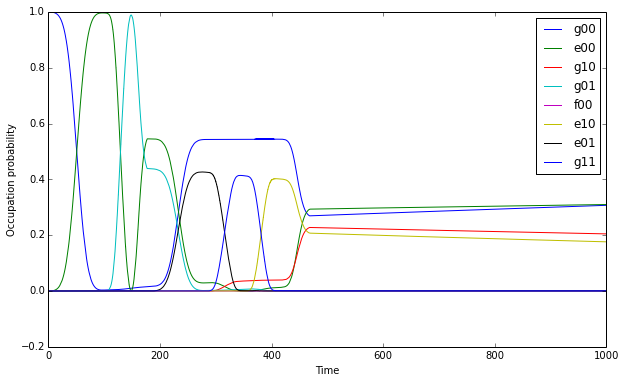

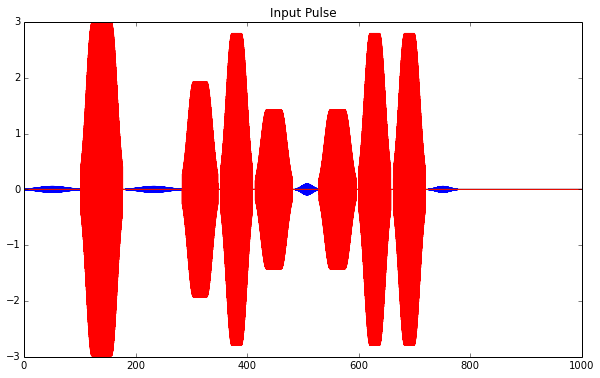

10.0%. Run time: 140.09s. Est. time left: 00:00:21:00
20.0%. Run time: 275.37s. Est. time left: 00:00:18:21
30.0%. Run time: 406.63s. Est. time left: 00:00:15:48
40.0%. Run time: 546.33s. Est. time left: 00:00:13:39
50.0%. Run time: 680.07s. Est. time left: 00:00:11:20
60.0%. Run time: 811.78s. Est. time left: 00:00:09:01
70.0%. Run time: 963.63s. Est. time left: 00:00:06:52
80.0%. Run time: 1082.41s. Est. time left: 00:00:04:30
90.0%. Run time: 1158.77s. Est. time left: 00:00:02:08
Total run time: 1234.76s
0.507412284659


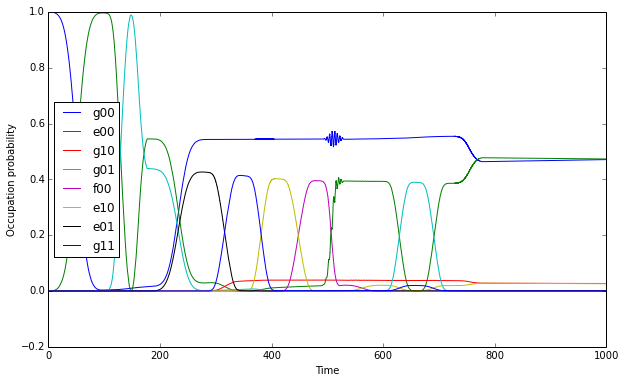

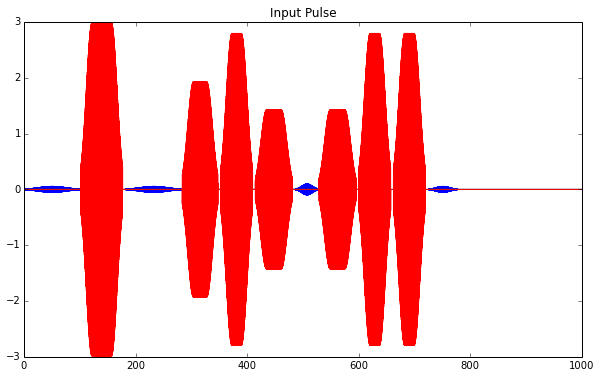

10.0%. Run time: 141.75s. Est. time left: 00:00:21:15
20.0%. Run time: 279.06s. Est. time left: 00:00:18:36
30.0%. Run time: 411.62s. Est. time left: 00:00:16:00
40.0%. Run time: 553.48s. Est. time left: 00:00:13:50
50.0%. Run time: 689.95s. Est. time left: 00:00:11:29
60.0%. Run time: 821.49s. Est. time left: 00:00:09:07
70.0%. Run time: 968.40s. Est. time left: 00:00:06:55
80.0%. Run time: 1092.26s. Est. time left: 00:00:04:33
90.0%. Run time: 1175.46s. Est. time left: 00:00:02:10
Total run time: 1253.89s
0.948437282456


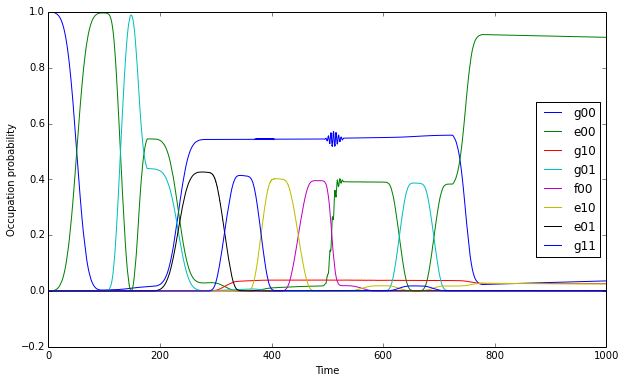

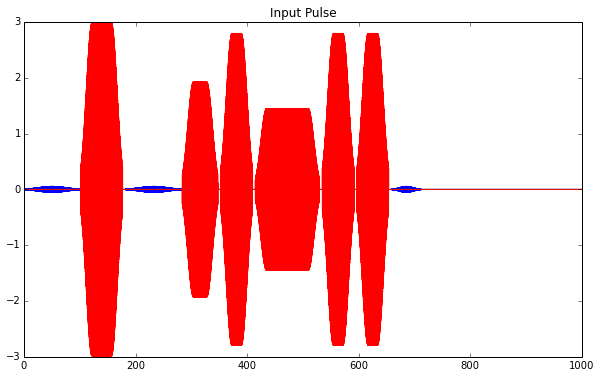

10.0%. Run time: 140.67s. Est. time left: 00:00:21:06
20.0%. Run time: 277.92s. Est. time left: 00:00:18:31
30.0%. Run time: 420.42s. Est. time left: 00:00:16:20
40.0%. Run time: 561.89s. Est. time left: 00:00:14:02
50.0%. Run time: 702.58s. Est. time left: 00:00:11:42
60.0%. Run time: 844.73s. Est. time left: 00:00:09:23
70.0%. Run time: 985.14s. Est. time left: 00:00:07:02
80.0%. Run time: 1113.78s. Est. time left: 00:00:04:38
90.0%. Run time: 1241.89s. Est. time left: 00:00:02:17
Total run time: 1369.82s
0.484058203885


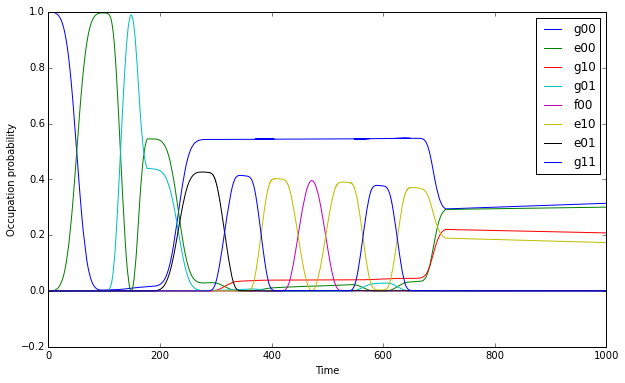

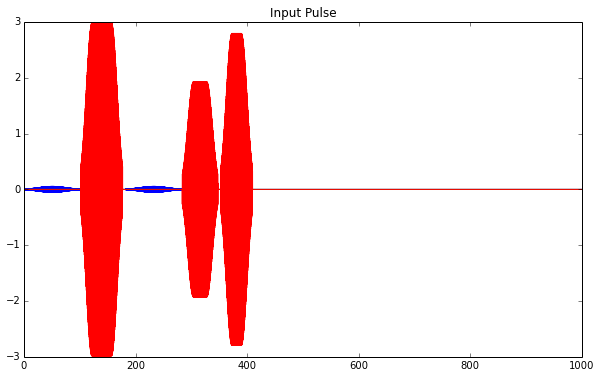

10.0%. Run time: 140.95s. Est. time left: 00:00:21:08
20.0%. Run time: 277.21s. Est. time left: 00:00:18:28
30.0%. Run time: 410.01s. Est. time left: 00:00:15:56
40.0%. Run time: 551.51s. Est. time left: 00:00:13:47
50.0%. Run time: 687.95s. Est. time left: 00:00:11:27
60.0%. Run time: 826.02s. Est. time left: 00:00:09:10
70.0%. Run time: 969.19s. Est. time left: 00:00:06:55
80.0%. Run time: 1107.12s. Est. time left: 00:00:04:36
90.0%. Run time: 1244.84s. Est. time left: 00:00:02:18
Total run time: 1382.52s
0.41544521478


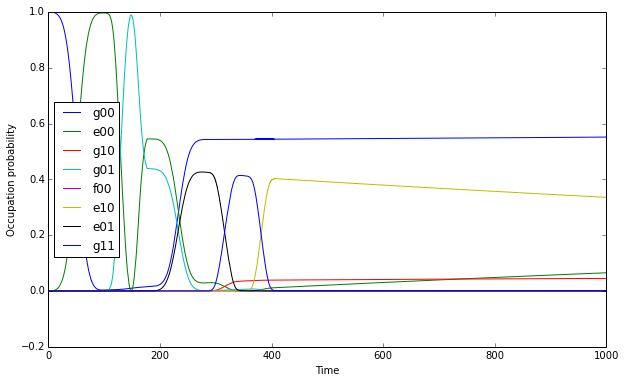

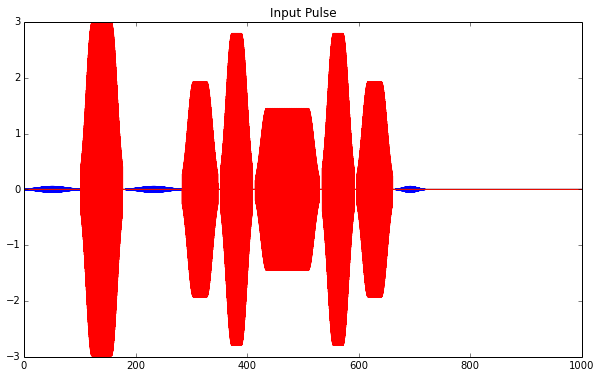

10.0%. Run time: 140.21s. Est. time left: 00:00:21:01
20.0%. Run time: 276.03s. Est. time left: 00:00:18:24
30.0%. Run time: 408.63s. Est. time left: 00:00:15:53
40.0%. Run time: 549.32s. Est. time left: 00:00:13:43
50.0%. Run time: 689.08s. Est. time left: 00:00:11:29
60.0%. Run time: 831.25s. Est. time left: 00:00:09:14
70.0%. Run time: 962.29s. Est. time left: 00:00:06:52
80.0%. Run time: 1090.59s. Est. time left: 00:00:04:32
90.0%. Run time: 1217.90s. Est. time left: 00:00:02:15
Total run time: 1345.76s
0.51873746025


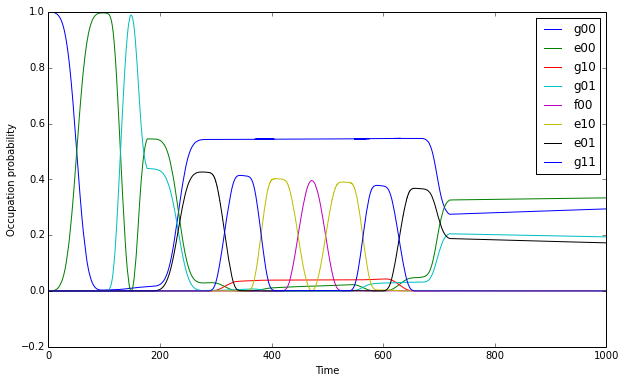

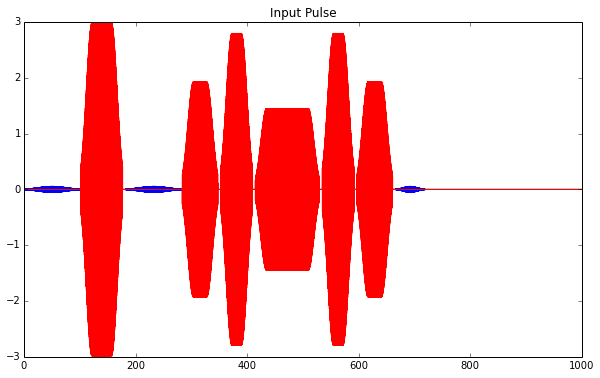

10.0%. Run time: 145.43s. Est. time left: 00:00:21:48
20.0%. Run time: 283.35s. Est. time left: 00:00:18:53
30.0%. Run time: 415.24s. Est. time left: 00:00:16:08
40.0%. Run time: 555.98s. Est. time left: 00:00:13:53
50.0%. Run time: 695.64s. Est. time left: 00:00:11:35
60.0%. Run time: 837.77s. Est. time left: 00:00:09:18
70.0%. Run time: 970.96s. Est. time left: 00:00:06:56
80.0%. Run time: 1100.21s. Est. time left: 00:00:04:35
90.0%. Run time: 1228.57s. Est. time left: 00:00:02:16
Total run time: 1356.49s
0.493682910068


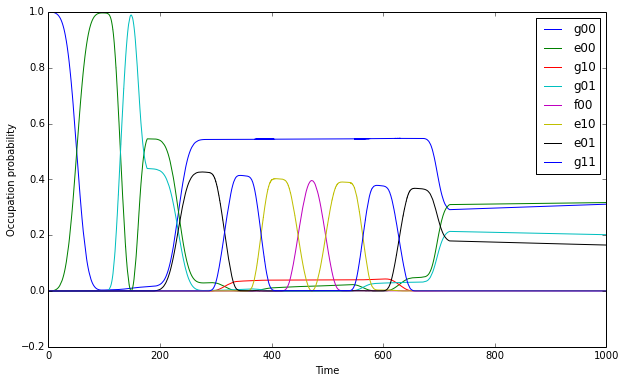

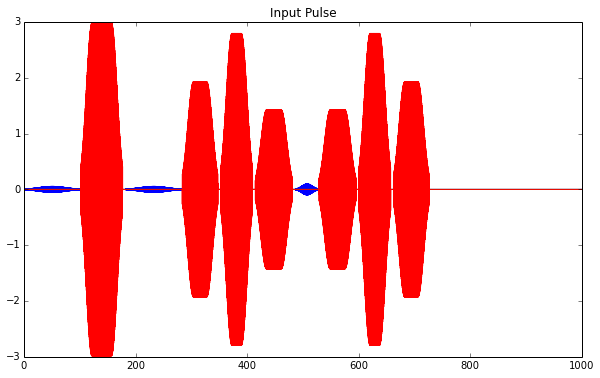

10.0%. Run time: 140.66s. Est. time left: 00:00:21:05
20.0%. Run time: 276.96s. Est. time left: 00:00:18:27
30.0%. Run time: 408.93s. Est. time left: 00:00:15:54
40.0%. Run time: 549.85s. Est. time left: 00:00:13:44
50.0%. Run time: 685.40s. Est. time left: 00:00:11:25
60.0%. Run time: 825.26s. Est. time left: 00:00:09:10
70.0%. Run time: 965.11s. Est. time left: 00:00:06:53
80.0%. Run time: 1062.53s. Est. time left: 00:00:04:25
90.0%. Run time: 1148.23s. Est. time left: 00:00:02:07
Total run time: 1227.66s
0.0587574089951


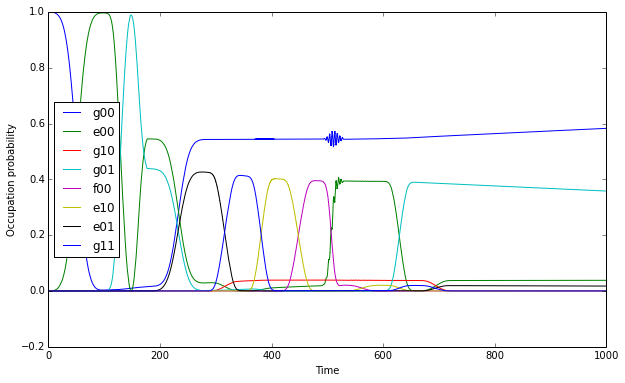

In [49]:
def GHZ_tomo():
    sys_para = SystemParameters()
    sys_para.update_total_time(1000)
    
    tomo_measure_e = []
    
    def prepare_GHZ(sys_para):
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = initiate_pulse(sys_para)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_3pi2_pulse)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    for tomo_index in range(15):
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = prepare_GHZ(sys_para)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = tomo_pulse(sys_para, tomo_index, Hx_pulse, Hy_pulse, Hz_pulse, time, 2.56669516063)

        measure_e = run_experiment(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time = time, run=True)
        tomo_measure_e.append(measure_e)
        
        np.save("./data/ghz_tomo", np.array(tomo_measure_e))
        
GHZ_tomo()

[ 0.53277344  0.51028404  0.44478453  0.4687734   0.94895984  0.49588962
  0.50479035  0.50215655  0.50741228  0.94843728  0.4840582   0.41544521
  0.51873746  0.49368291  0.05875741]


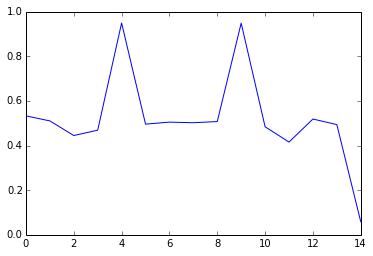

In [52]:
ghz_tomo = np.load("./data/ghz_tomo/ghz_tomo.npy")
plt.plot(ghz_tomo)
print ghz_tomo

Phase: -3.14159265359


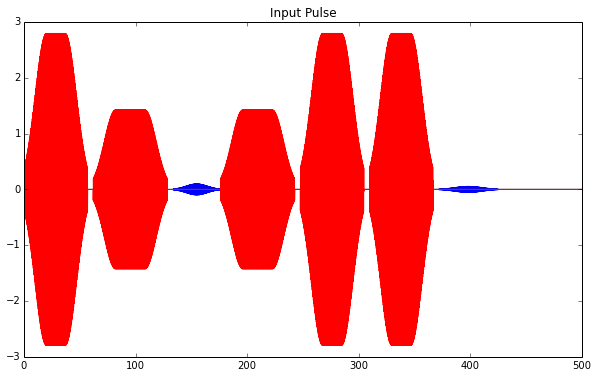

10.0%. Run time:  63.70s. Est. time left: 00:00:09:33
20.0%. Run time: 107.43s. Est. time left: 00:00:07:09
30.0%. Run time: 148.87s. Est. time left: 00:00:05:47
40.0%. Run time: 197.20s. Est. time left: 00:00:04:55
50.0%. Run time: 248.81s. Est. time left: 00:00:04:08
60.0%. Run time: 312.37s. Est. time left: 00:00:03:28
70.0%. Run time: 374.86s. Est. time left: 00:00:02:40
80.0%. Run time: 431.74s. Est. time left: 00:00:01:47
90.0%. Run time: 485.33s. Est. time left: 00:00:00:53
Total run time: 537.43s
0.766954660245
Phase: -2.44346095279


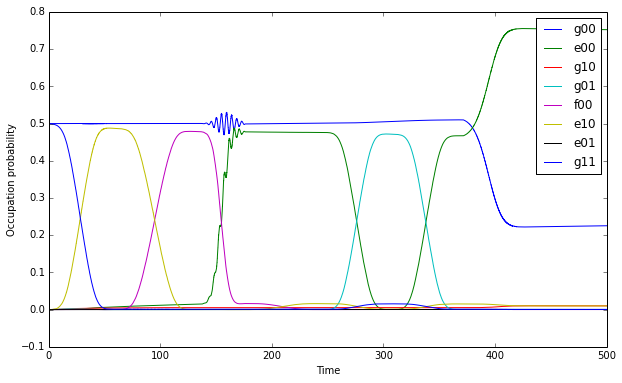

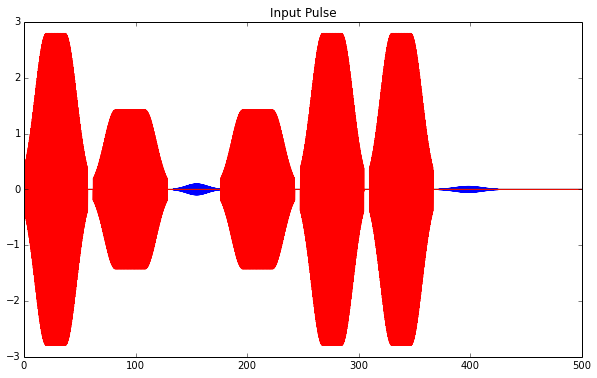

10.0%. Run time:  63.94s. Est. time left: 00:00:09:35
20.0%. Run time: 107.68s. Est. time left: 00:00:07:10
30.0%. Run time: 149.04s. Est. time left: 00:00:05:47
40.0%. Run time: 197.72s. Est. time left: 00:00:04:56
50.0%. Run time: 249.73s. Est. time left: 00:00:04:09
60.0%. Run time: 313.80s. Est. time left: 00:00:03:29
70.0%. Run time: 376.76s. Est. time left: 00:00:02:41
80.0%. Run time: 433.15s. Est. time left: 00:00:01:48
90.0%. Run time: 478.98s. Est. time left: 00:00:00:53
Total run time: 514.98s
0.441885336015
Phase: -1.74532925199


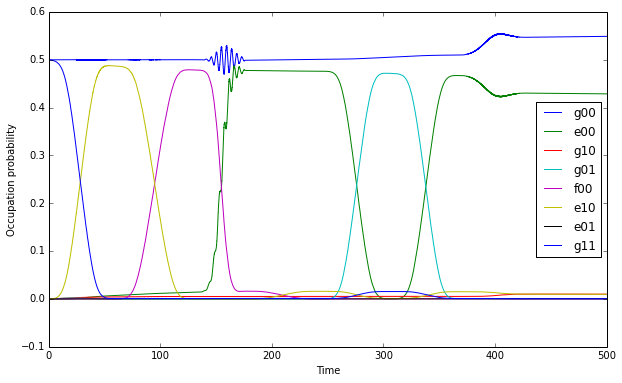

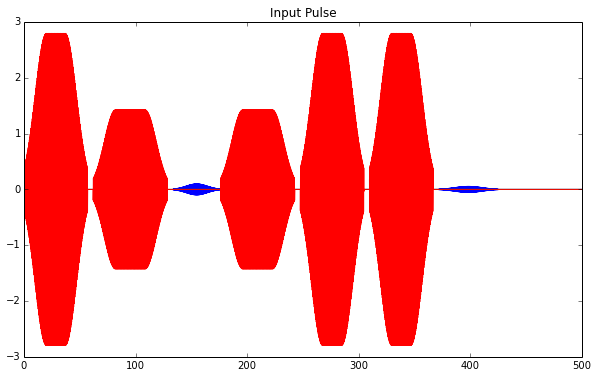

10.0%. Run time:  63.85s. Est. time left: 00:00:09:34
20.0%. Run time: 107.89s. Est. time left: 00:00:07:11
30.0%. Run time: 149.24s. Est. time left: 00:00:05:48
40.0%. Run time: 197.66s. Est. time left: 00:00:04:56
50.0%. Run time: 249.14s. Est. time left: 00:00:04:09
60.0%. Run time: 312.78s. Est. time left: 00:00:03:28
70.0%. Run time: 374.97s. Est. time left: 00:00:02:40
80.0%. Run time: 430.81s. Est. time left: 00:00:01:47
90.0%. Run time: 484.71s. Est. time left: 00:00:00:53
Total run time: 537.58s
0.142622561406
Phase: -1.0471975512


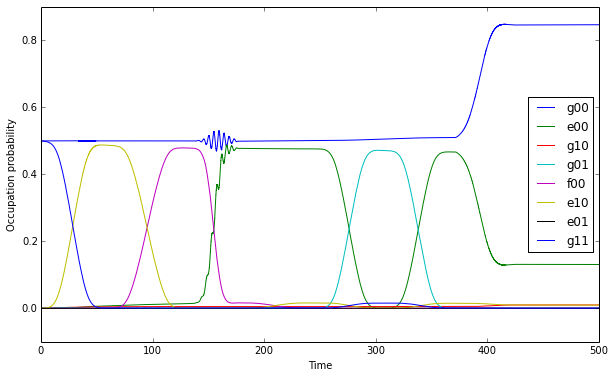

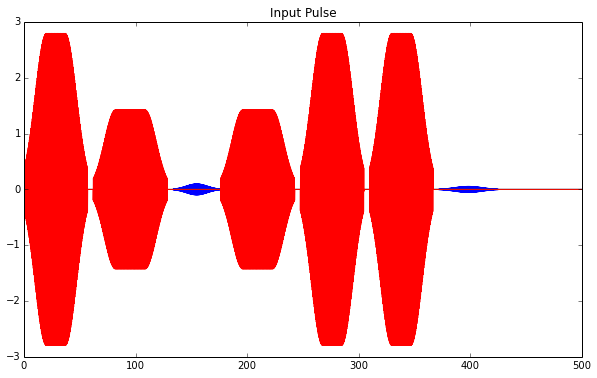

10.0%. Run time:  63.68s. Est. time left: 00:00:09:33
20.0%. Run time: 107.09s. Est. time left: 00:00:07:08
30.0%. Run time: 148.22s. Est. time left: 00:00:05:45
40.0%. Run time: 196.22s. Est. time left: 00:00:04:54
50.0%. Run time: 247.49s. Est. time left: 00:00:04:07
60.0%. Run time: 310.60s. Est. time left: 00:00:03:27
70.0%. Run time: 372.40s. Est. time left: 00:00:02:39
80.0%. Run time: 427.49s. Est. time left: 00:00:01:46
90.0%. Run time: 481.38s. Est. time left: 00:00:00:53
Total run time: 534.15s
0.00436157889838
Phase: -0.349065850399


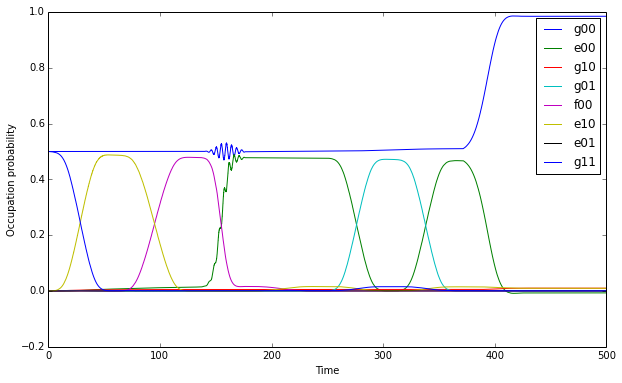

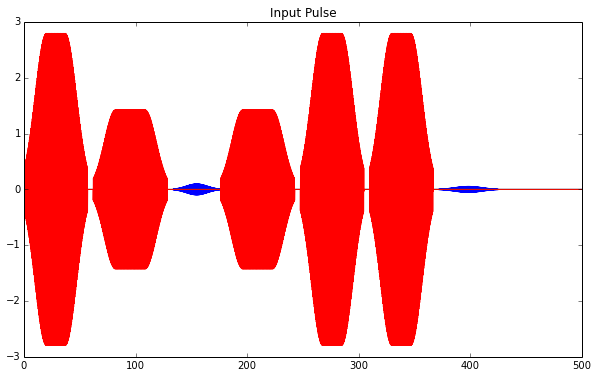

10.0%. Run time:  63.47s. Est. time left: 00:00:09:31
20.0%. Run time: 107.12s. Est. time left: 00:00:07:08
30.0%. Run time: 148.51s. Est. time left: 00:00:05:46
40.0%. Run time: 196.77s. Est. time left: 00:00:04:55
50.0%. Run time: 248.26s. Est. time left: 00:00:04:08
60.0%. Run time: 311.70s. Est. time left: 00:00:03:27
70.0%. Run time: 374.12s. Est. time left: 00:00:02:40
80.0%. Run time: 424.56s. Est. time left: 00:00:01:46
90.0%. Run time: 475.16s. Est. time left: 00:00:00:52
Total run time: 524.87s
0.0924000070375
Phase: 0.349065850399


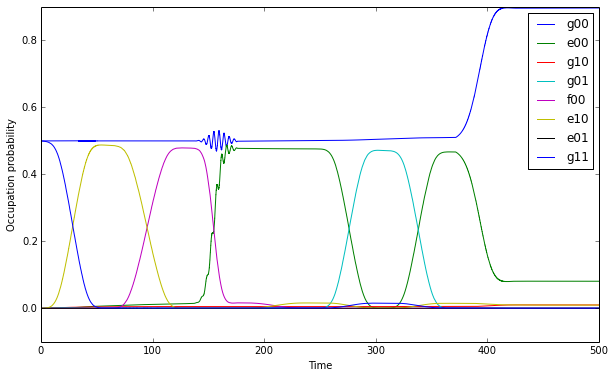

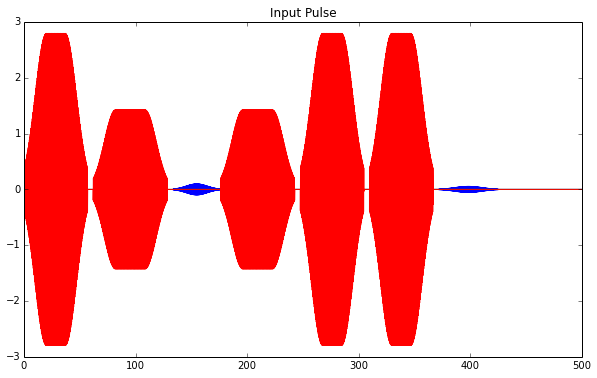

10.0%. Run time:  63.33s. Est. time left: 00:00:09:29
20.0%. Run time: 106.78s. Est. time left: 00:00:07:07
30.0%. Run time: 148.10s. Est. time left: 00:00:05:45
40.0%. Run time: 196.39s. Est. time left: 00:00:04:54
50.0%. Run time: 248.02s. Est. time left: 00:00:04:08
60.0%. Run time: 312.33s. Est. time left: 00:00:03:28
70.0%. Run time: 378.00s. Est. time left: 00:00:02:41
80.0%. Run time: 433.62s. Est. time left: 00:00:01:48
90.0%. Run time: 486.84s. Est. time left: 00:00:00:54
Total run time: 538.57s
0.375661496913
Phase: 1.0471975512


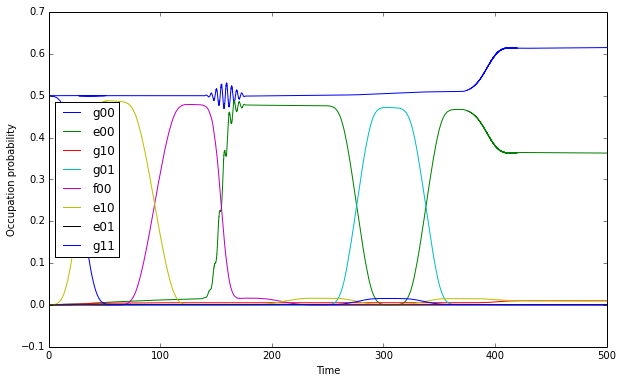

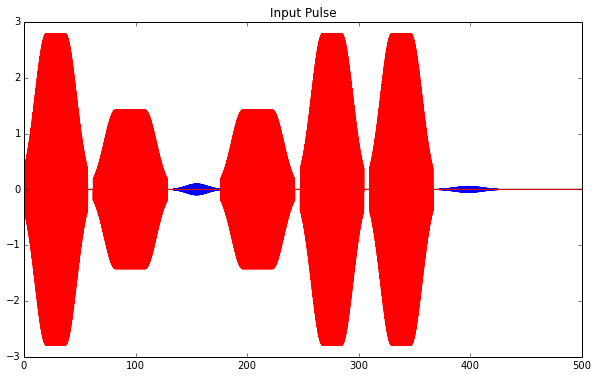

10.0%. Run time:  63.52s. Est. time left: 00:00:09:31
20.0%. Run time: 107.20s. Est. time left: 00:00:07:08
30.0%. Run time: 148.34s. Est. time left: 00:00:05:46
40.0%. Run time: 196.45s. Est. time left: 00:00:04:54
50.0%. Run time: 248.06s. Est. time left: 00:00:04:08
60.0%. Run time: 311.56s. Est. time left: 00:00:03:27
70.0%. Run time: 373.54s. Est. time left: 00:00:02:40
80.0%. Run time: 429.72s. Est. time left: 00:00:01:47
90.0%. Run time: 483.93s. Est. time left: 00:00:00:53
Total run time: 535.52s
0.719018315486
Phase: 1.74532925199


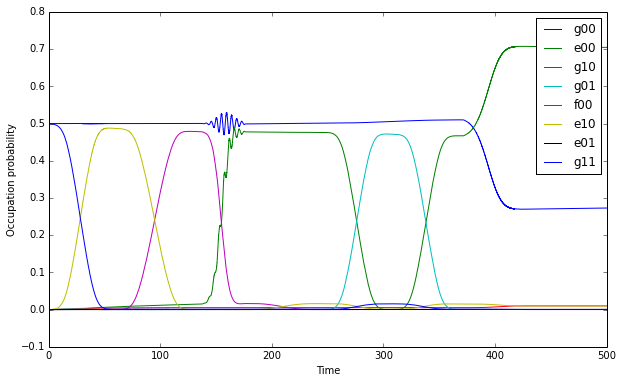

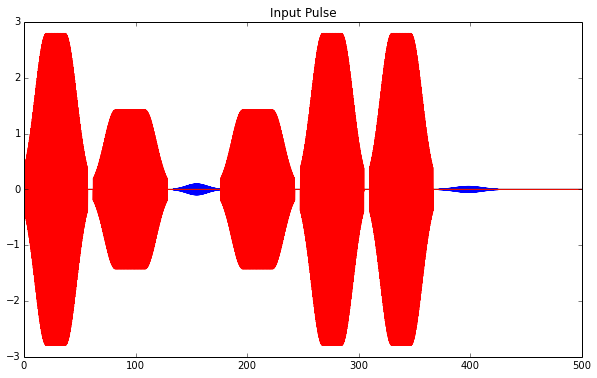

10.0%. Run time:  64.03s. Est. time left: 00:00:09:36
20.0%. Run time: 107.79s. Est. time left: 00:00:07:11
30.0%. Run time: 149.18s. Est. time left: 00:00:05:48
40.0%. Run time: 197.36s. Est. time left: 00:00:04:56
50.0%. Run time: 249.10s. Est. time left: 00:00:04:09
60.0%. Run time: 312.24s. Est. time left: 00:00:03:28
70.0%. Run time: 374.15s. Est. time left: 00:00:02:40
80.0%. Run time: 431.25s. Est. time left: 00:00:01:47
90.0%. Run time: 476.10s. Est. time left: 00:00:00:52
Total run time: 509.58s
0.957971821988
Phase: 2.44346095279


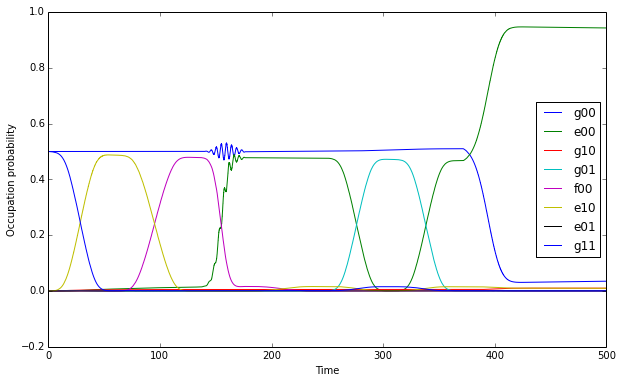

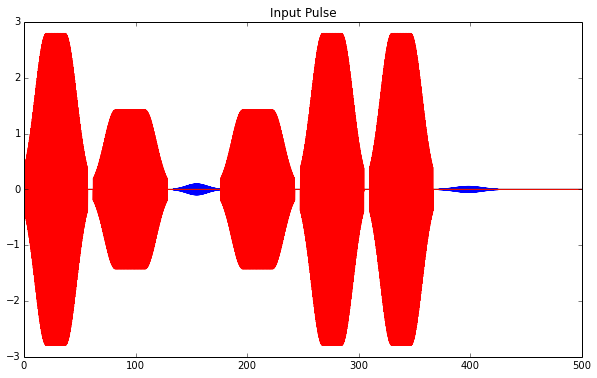

10.0%. Run time:  63.24s. Est. time left: 00:00:09:29
20.0%. Run time: 106.74s. Est. time left: 00:00:07:06
30.0%. Run time: 147.96s. Est. time left: 00:00:05:45
40.0%. Run time: 196.04s. Est. time left: 00:00:04:54
50.0%. Run time: 247.05s. Est. time left: 00:00:04:07
60.0%. Run time: 309.85s. Est. time left: 00:00:03:26
70.0%. Run time: 371.56s. Est. time left: 00:00:02:39
80.0%. Run time: 425.32s. Est. time left: 00:00:01:46
90.0%. Run time: 477.61s. Est. time left: 00:00:00:53
Total run time: 528.34s
0.974144817671
Phase: 3.14159265359


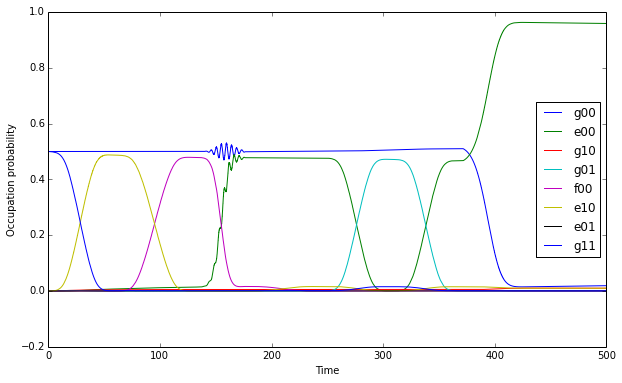

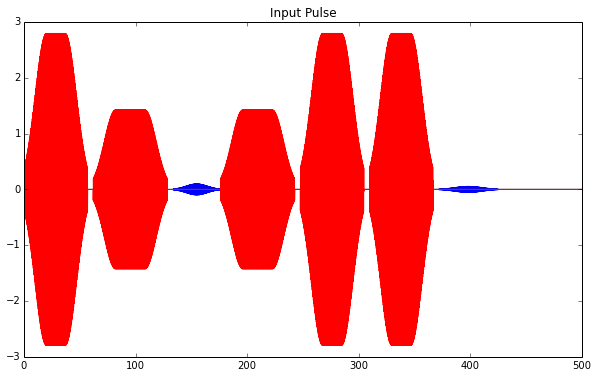

10.0%. Run time:  63.33s. Est. time left: 00:00:09:29
20.0%. Run time: 106.63s. Est. time left: 00:00:07:06
30.0%. Run time: 148.35s. Est. time left: 00:00:05:46
40.0%. Run time: 196.46s. Est. time left: 00:00:04:54
50.0%. Run time: 247.53s. Est. time left: 00:00:04:07
60.0%. Run time: 310.36s. Est. time left: 00:00:03:26
70.0%. Run time: 372.37s. Est. time left: 00:00:02:39
80.0%. Run time: 428.98s. Est. time left: 00:00:01:47
90.0%. Run time: 473.11s. Est. time left: 00:00:00:52
Total run time: 506.41s
0.766956694949


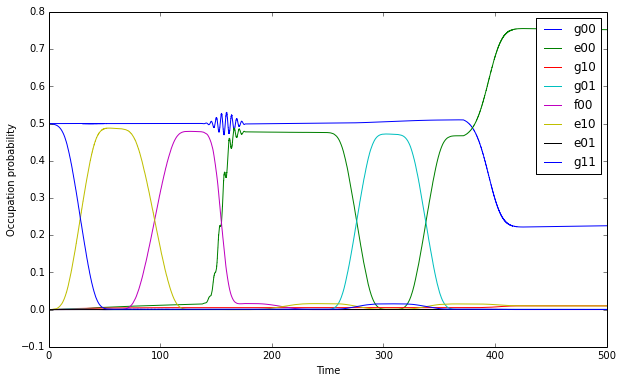

In [73]:
def GHZ_ideal_XX_phase_sweep():
    sys_para = SystemParameters()
    sys_para.update_total_time(500)
    
    tomo_measure_e = []
    
    ghz_ideal = (Qobj(sys_para.H0).eigenstates()[1][0]+Qobj(sys_para.H0).eigenstates()[1][8])/(np.sqrt(2))
    ghz_rho = ghz_ideal * ghz_ideal.dag()
    
    for phase in np.linspace(-np.pi,np.pi,10):
        print "Phase: " + str(phase)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = initiate_pulse(sys_para)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CX(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse, phase = phase)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse,phase = np.pi/2)

        measure_e = run_experiment(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time = time, run=True, init_state = ghz_rho)
        tomo_measure_e.append(measure_e)
        
        np.save("./data/ghz_ideal_xx_phase_sweep", np.array(tomo_measure_e))
        
GHZ_ideal_XX_phase_sweep()

[ 0.76695466  0.44188534  0.14262256  0.00436158  0.09240001  0.3756615
  0.71901832  0.95797182  0.97414482  0.76695669]
2.12831034042


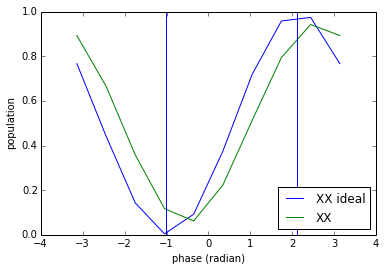

In [80]:
ghz_ideal_xx_phase_sweep = np.load("./data/ghz_ideal_xx_phase_sweep/ghz_ideal_xx_phase_sweep.npy")
plt.plot(np.linspace(-np.pi,np.pi,10),ghz_ideal_xx_phase_sweep,label='XX ideal')

ghz_xx_phase_sweep = np.load("./data/ghz_xx_phase_sweep/ghz_xx_phase_sweep.npy")
plt.plot(np.linspace(-np.pi,np.pi,10),ghz_xx_phase_sweep,label='XX')

minimum_phase = (3.14159265359-2.44346095279)*(4.04858-1)-np.pi
plt.axvline(minimum_phase)

maximum_phase = (3.14159265359-2.44346095279)*(4.04858-1)
plt.axvline(maximum_phase)

plt.ylabel("population")
plt.xlabel("phase (radian)")
plt.ylabel("population")
plt.xlabel("phase (radian)")
plt.legend(loc='0')

print ghz_ideal_xx_phase_sweep
print maximum_phase

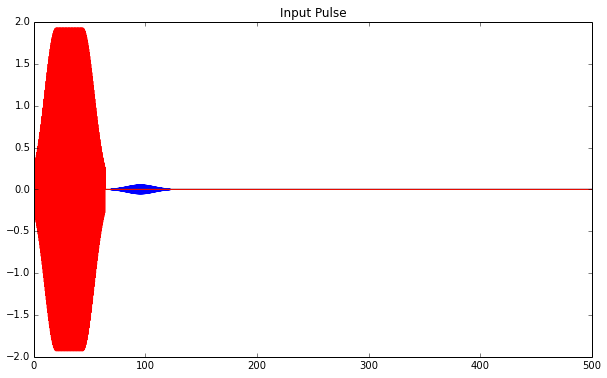

10.0%. Run time:  47.83s. Est. time left: 00:00:07:10
20.0%. Run time:  87.55s. Est. time left: 00:00:05:50
30.0%. Run time: 125.41s. Est. time left: 00:00:04:52
40.0%. Run time: 158.27s. Est. time left: 00:00:03:57
50.0%. Run time: 191.27s. Est. time left: 00:00:03:11
60.0%. Run time: 237.97s. Est. time left: 00:00:02:38
70.0%. Run time: 284.68s. Est. time left: 00:00:02:02
80.0%. Run time: 331.39s. Est. time left: 00:00:01:22
90.0%. Run time: 378.01s. Est. time left: 00:00:00:42
Total run time: 424.44s
0.499349868876


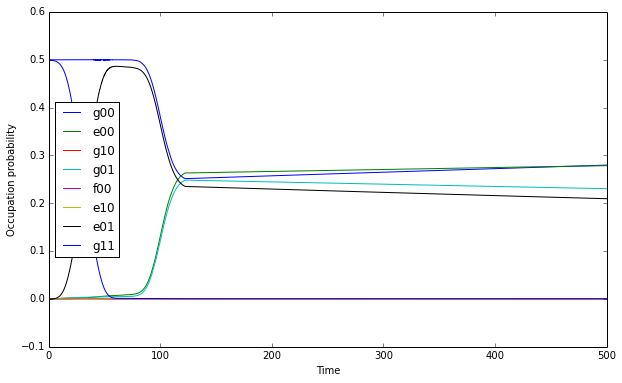

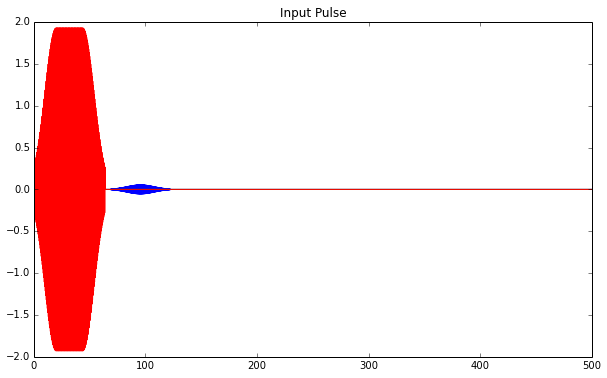

10.0%. Run time:  46.99s. Est. time left: 00:00:07:02
20.0%. Run time:  86.06s. Est. time left: 00:00:05:44
30.0%. Run time: 123.87s. Est. time left: 00:00:04:49
40.0%. Run time: 157.16s. Est. time left: 00:00:03:55
50.0%. Run time: 190.48s. Est. time left: 00:00:03:10
60.0%. Run time: 224.57s. Est. time left: 00:00:02:29
70.0%. Run time: 272.10s. Est. time left: 00:00:01:56
80.0%. Run time: 319.71s. Est. time left: 00:00:01:19
90.0%. Run time: 367.35s. Est. time left: 00:00:00:40
Total run time: 414.96s
0.499350935091


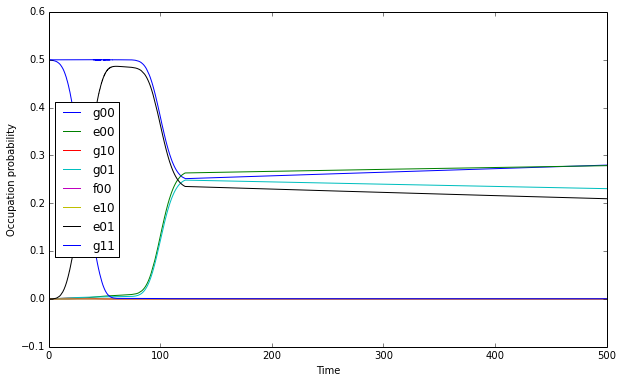

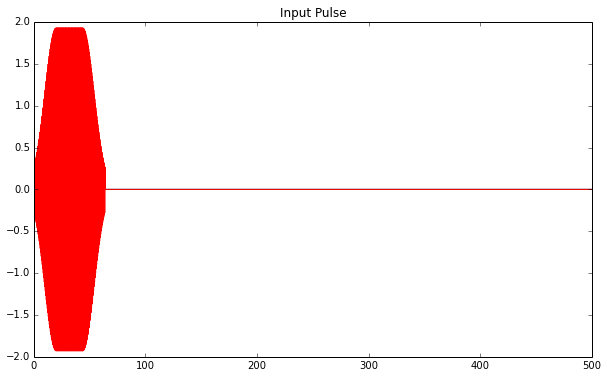

10.0%. Run time:  47.49s. Est. time left: 00:00:07:07
20.0%. Run time:  75.06s. Est. time left: 00:00:05:00
30.0%. Run time:  99.48s. Est. time left: 00:00:03:52
40.0%. Run time: 123.82s. Est. time left: 00:00:03:05
50.0%. Run time: 148.19s. Est. time left: 00:00:02:28
60.0%. Run time: 172.54s. Est. time left: 00:00:01:55
70.0%. Run time: 196.90s. Est. time left: 00:00:01:24
80.0%. Run time: 221.35s. Est. time left: 00:00:00:55
90.0%. Run time: 245.86s. Est. time left: 00:00:00:27
Total run time: 270.31s
0.493799362322


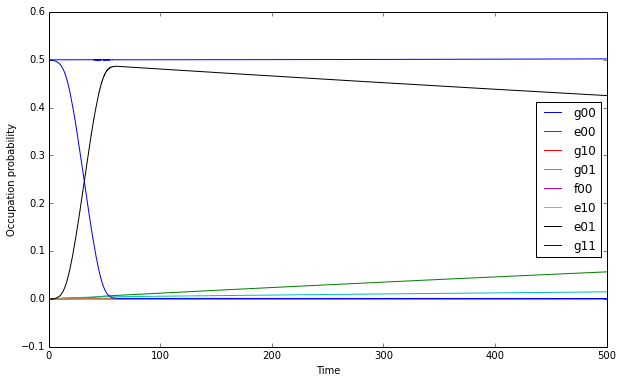

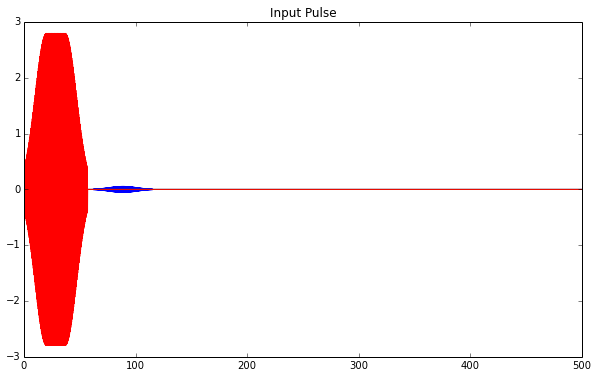

10.0%. Run time:  63.25s. Est. time left: 00:00:09:29
20.0%. Run time: 104.58s. Est. time left: 00:00:06:58
30.0%. Run time: 138.69s. Est. time left: 00:00:05:23
40.0%. Run time: 171.30s. Est. time left: 00:00:04:16
50.0%. Run time: 214.47s. Est. time left: 00:00:03:34
60.0%. Run time: 260.90s. Est. time left: 00:00:02:53
70.0%. Run time: 307.60s. Est. time left: 00:00:02:11
80.0%. Run time: 354.47s. Est. time left: 00:00:01:28
90.0%. Run time: 401.15s. Est. time left: 00:00:00:44
Total run time: 447.57s
0.499468562232


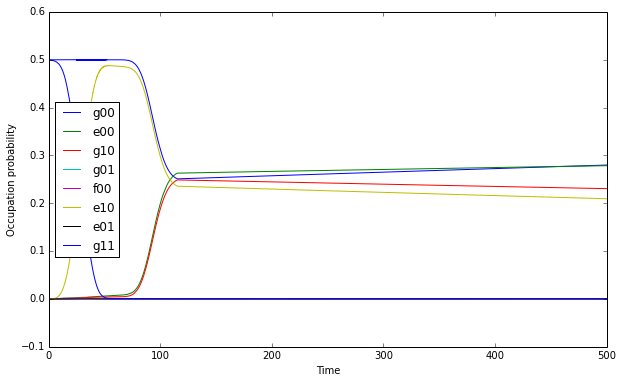

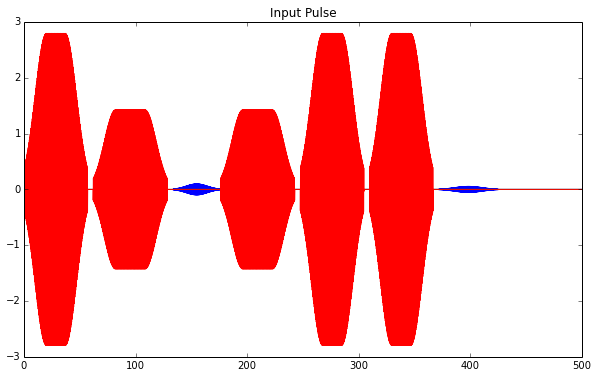

10.0%. Run time:  63.41s. Est. time left: 00:00:09:30
20.0%. Run time: 106.92s. Est. time left: 00:00:07:07
30.0%. Run time: 147.99s. Est. time left: 00:00:05:45
40.0%. Run time: 196.12s. Est. time left: 00:00:04:54
50.0%. Run time: 247.32s. Est. time left: 00:00:04:07
60.0%. Run time: 310.73s. Est. time left: 00:00:03:27
70.0%. Run time: 372.77s. Est. time left: 00:00:02:39
80.0%. Run time: 429.47s. Est. time left: 00:00:01:47
90.0%. Run time: 474.92s. Est. time left: 00:00:00:52
Total run time: 508.69s
0.996930036406


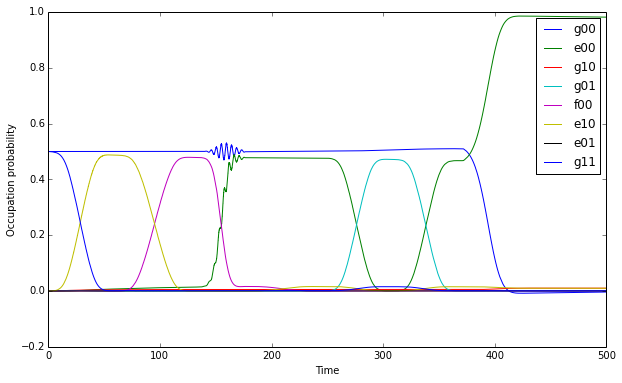

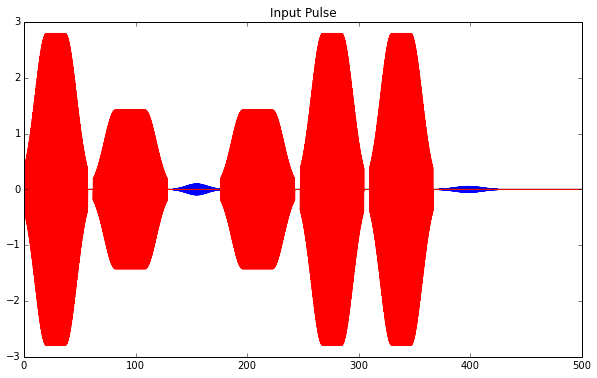

10.0%. Run time:  63.57s. Est. time left: 00:00:09:32
20.0%. Run time: 107.38s. Est. time left: 00:00:07:09
30.0%. Run time: 149.02s. Est. time left: 00:00:05:47
40.0%. Run time: 192.27s. Est. time left: 00:00:04:48
50.0%. Run time: 242.95s. Est. time left: 00:00:04:02
60.0%. Run time: 308.02s. Est. time left: 00:00:03:25
70.0%. Run time: 368.88s. Est. time left: 00:00:02:38
80.0%. Run time: 422.69s. Est. time left: 00:00:01:45
90.0%. Run time: 465.70s. Est. time left: 00:00:00:51
Total run time: 497.48s
0.512353182609


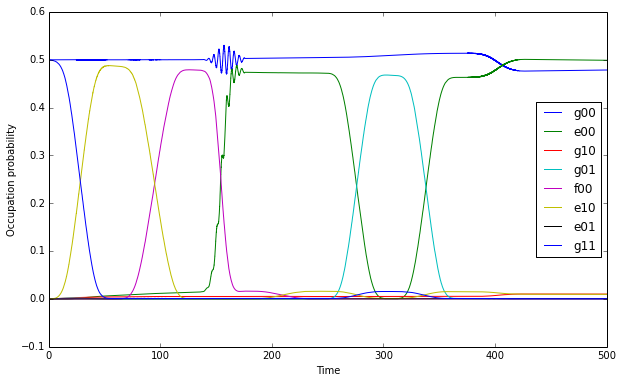

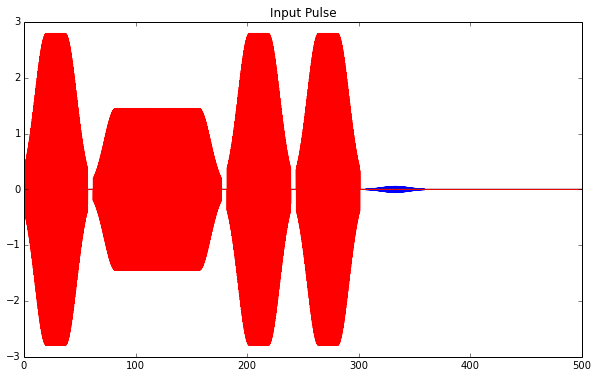

10.0%. Run time:  63.70s. Est. time left: 00:00:09:33
20.0%. Run time: 108.16s. Est. time left: 00:00:07:12
30.0%. Run time: 165.40s. Est. time left: 00:00:06:25
40.0%. Run time: 218.06s. Est. time left: 00:00:05:27
50.0%. Run time: 282.60s. Est. time left: 00:00:04:42
60.0%. Run time: 351.37s. Est. time left: 00:00:03:54
70.0%. Run time: 408.81s. Est. time left: 00:00:02:55
80.0%. Run time: 449.54s. Est. time left: 00:00:01:52
90.0%. Run time: 481.79s. Est. time left: 00:00:00:53
Total run time: 513.21s
0.500185190428


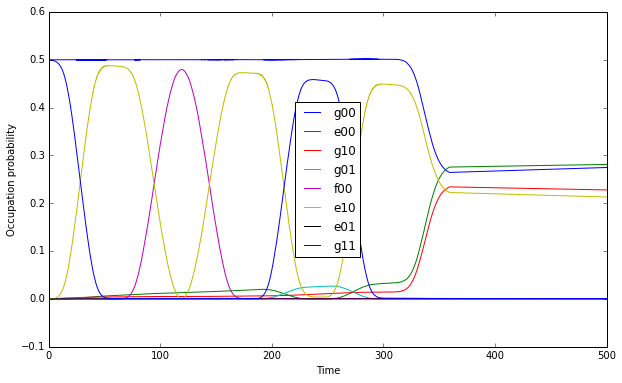

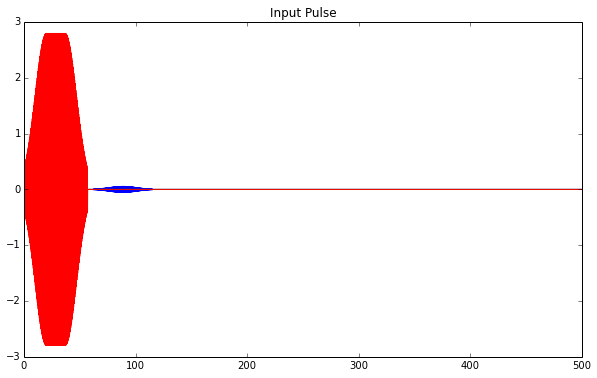

10.0%. Run time:  63.55s. Est. time left: 00:00:09:31
20.0%. Run time: 105.40s. Est. time left: 00:00:07:01
30.0%. Run time: 136.38s. Est. time left: 00:00:05:18
40.0%. Run time: 167.15s. Est. time left: 00:00:04:10
50.0%. Run time: 205.06s. Est. time left: 00:00:03:25
60.0%. Run time: 256.41s. Est. time left: 00:00:02:50
70.0%. Run time: 307.95s. Est. time left: 00:00:02:11
80.0%. Run time: 359.30s. Est. time left: 00:00:01:29
90.0%. Run time: 410.84s. Est. time left: 00:00:00:45
Total run time: 461.96s
0.499463214774


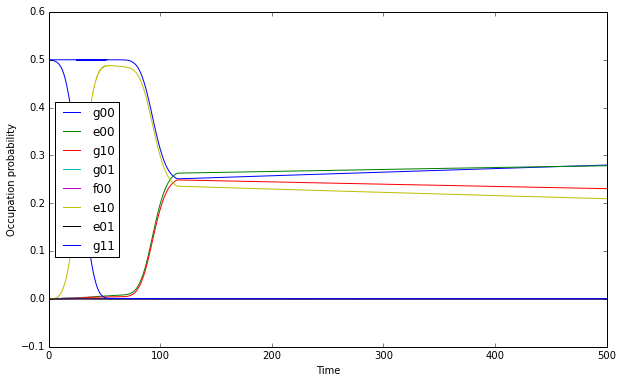

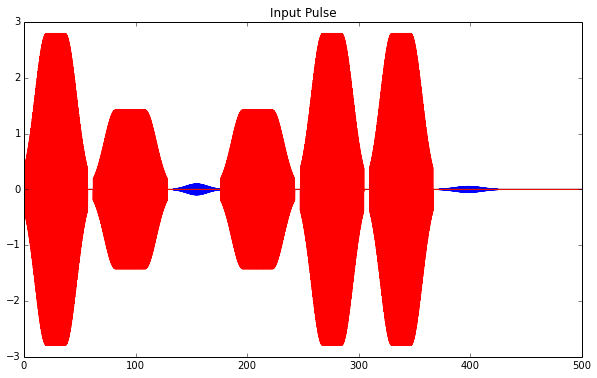

10.0%. Run time:  63.32s. Est. time left: 00:00:09:29
20.0%. Run time: 107.00s. Est. time left: 00:00:07:07
30.0%. Run time: 148.69s. Est. time left: 00:00:05:46
40.0%. Run time: 197.32s. Est. time left: 00:00:04:55
50.0%. Run time: 249.04s. Est. time left: 00:00:04:09
60.0%. Run time: 312.67s. Est. time left: 00:00:03:28
70.0%. Run time: 375.17s. Est. time left: 00:00:02:40
80.0%. Run time: 432.41s. Est. time left: 00:00:01:48
90.0%. Run time: 476.54s. Est. time left: 00:00:00:52
Total run time: 510.49s
0.492607644005


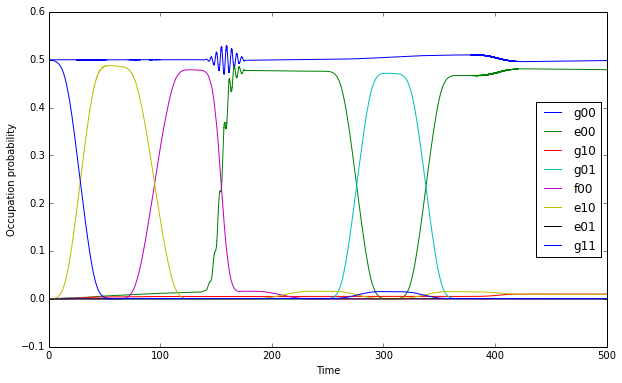

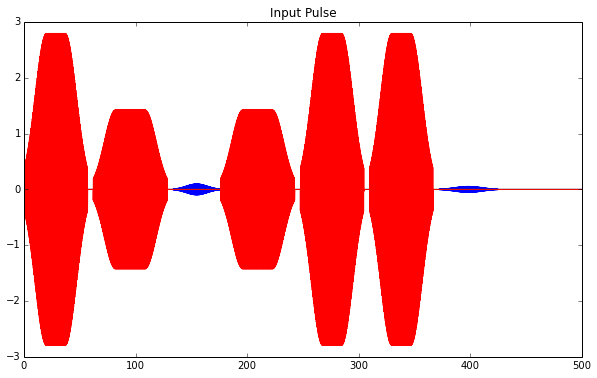

10.0%. Run time:  63.52s. Est. time left: 00:00:09:31
20.0%. Run time: 107.21s. Est. time left: 00:00:07:08
30.0%. Run time: 148.54s. Est. time left: 00:00:05:46
40.0%. Run time: 191.67s. Est. time left: 00:00:04:47
50.0%. Run time: 241.75s. Est. time left: 00:00:04:01
60.0%. Run time: 306.28s. Est. time left: 00:00:03:24
70.0%. Run time: 366.15s. Est. time left: 00:00:02:36
80.0%. Run time: 421.48s. Est. time left: 00:00:01:45
90.0%. Run time: 472.76s. Est. time left: 00:00:00:52
Total run time: 522.04s
0.996649993971


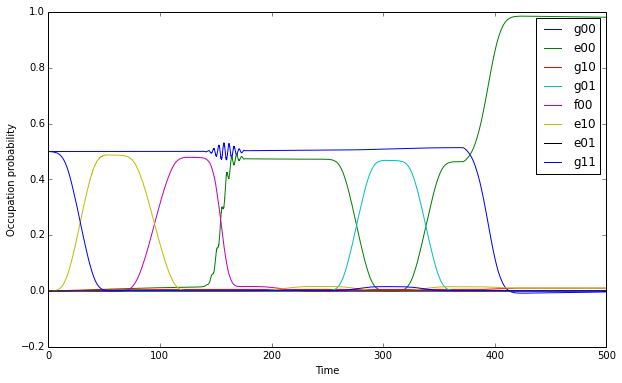

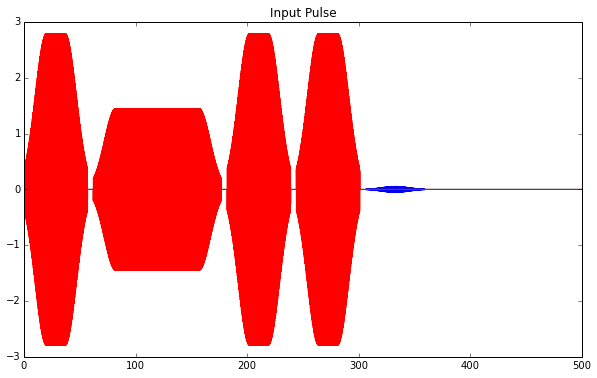

10.0%. Run time:  63.92s. Est. time left: 00:00:09:35
20.0%. Run time: 108.11s. Est. time left: 00:00:07:12
30.0%. Run time: 164.98s. Est. time left: 00:00:06:24
40.0%. Run time: 217.33s. Est. time left: 00:00:05:25
50.0%. Run time: 281.66s. Est. time left: 00:00:04:41
60.0%. Run time: 350.23s. Est. time left: 00:00:03:53
70.0%. Run time: 408.90s. Est. time left: 00:00:02:55
80.0%. Run time: 448.08s. Est. time left: 00:00:01:52
90.0%. Run time: 483.97s. Est. time left: 00:00:00:53
Total run time: 519.60s
0.500202813493


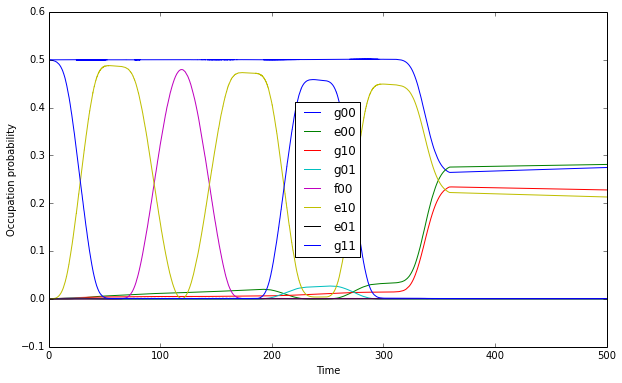

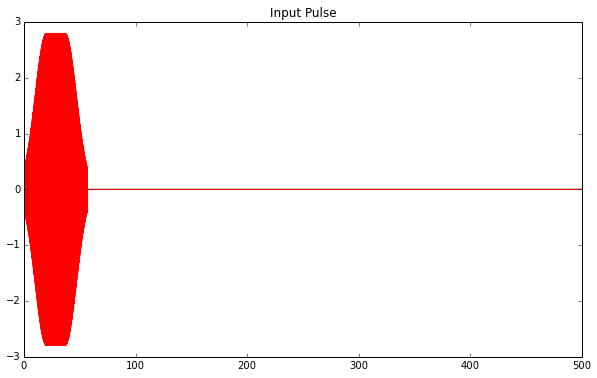

10.0%. Run time:  63.09s. Est. time left: 00:00:09:27
20.0%. Run time:  88.78s. Est. time left: 00:00:05:55
30.0%. Run time: 112.87s. Est. time left: 00:00:04:23
40.0%. Run time: 136.96s. Est. time left: 00:00:03:25
50.0%. Run time: 161.06s. Est. time left: 00:00:02:41
60.0%. Run time: 185.15s. Est. time left: 00:00:02:03
70.0%. Run time: 209.14s. Est. time left: 00:00:01:29
80.0%. Run time: 233.16s. Est. time left: 00:00:00:58
90.0%. Run time: 257.26s. Est. time left: 00:00:00:28
Total run time: 281.34s
0.494422000785


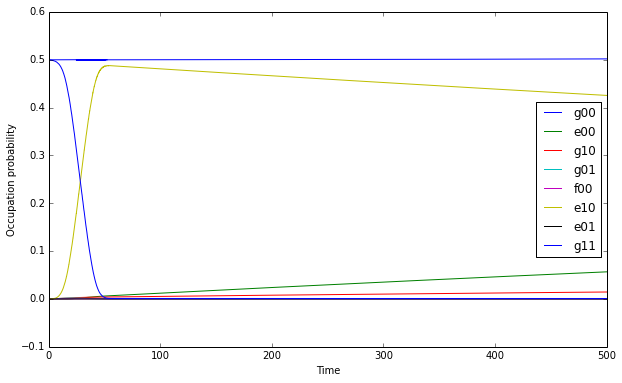

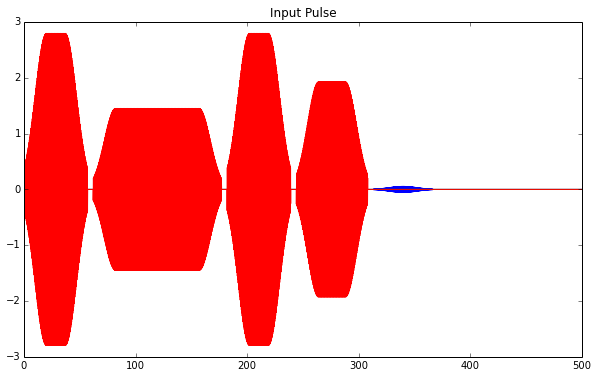

10.0%. Run time:  63.99s. Est. time left: 00:00:09:35
20.0%. Run time: 108.20s. Est. time left: 00:00:07:12
30.0%. Run time: 164.91s. Est. time left: 00:00:06:24
40.0%. Run time: 217.37s. Est. time left: 00:00:05:26
50.0%. Run time: 278.22s. Est. time left: 00:00:04:38
60.0%. Run time: 333.90s. Est. time left: 00:00:03:42
70.0%. Run time: 388.70s. Est. time left: 00:00:02:46
80.0%. Run time: 429.50s. Est. time left: 00:00:01:47
90.0%. Run time: 464.36s. Est. time left: 00:00:00:51
Total run time: 499.35s
0.501527323202


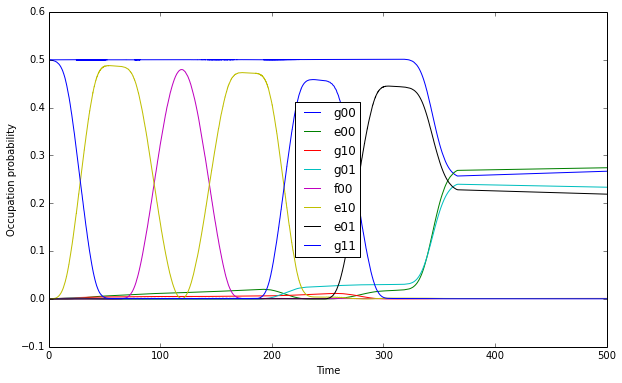

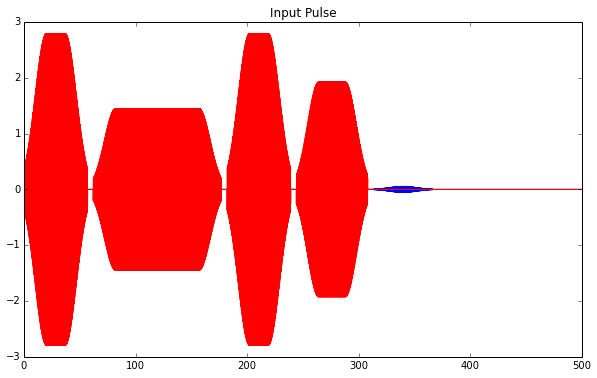

10.0%. Run time:  63.52s. Est. time left: 00:00:09:31
20.0%. Run time: 107.86s. Est. time left: 00:00:07:11
30.0%. Run time: 165.03s. Est. time left: 00:00:06:25
40.0%. Run time: 217.87s. Est. time left: 00:00:05:26
50.0%. Run time: 279.28s. Est. time left: 00:00:04:39
60.0%. Run time: 339.32s. Est. time left: 00:00:03:46
70.0%. Run time: 394.29s. Est. time left: 00:00:02:48
80.0%. Run time: 444.28s. Est. time left: 00:00:01:51
90.0%. Run time: 493.36s. Est. time left: 00:00:00:54
Total run time: 542.45s
0.501511577918


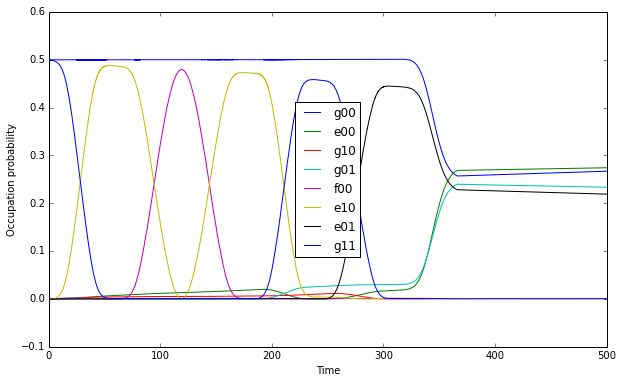

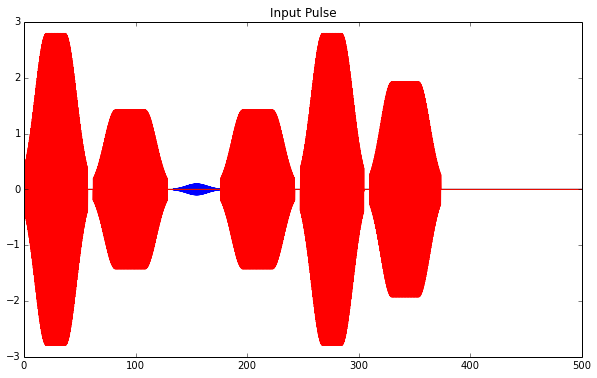

10.0%. Run time:  63.54s. Est. time left: 00:00:09:31
20.0%. Run time: 107.05s. Est. time left: 00:00:07:08
30.0%. Run time: 148.24s. Est. time left: 00:00:05:45
40.0%. Run time: 196.61s. Est. time left: 00:00:04:54
50.0%. Run time: 248.30s. Est. time left: 00:00:04:08
60.0%. Run time: 311.57s. Est. time left: 00:00:03:27
70.0%. Run time: 364.54s. Est. time left: 00:00:02:36
80.0%. Run time: 416.99s. Est. time left: 00:00:01:44
90.0%. Run time: 469.26s. Est. time left: 00:00:00:52
Total run time: 521.66s
0.0221251419906


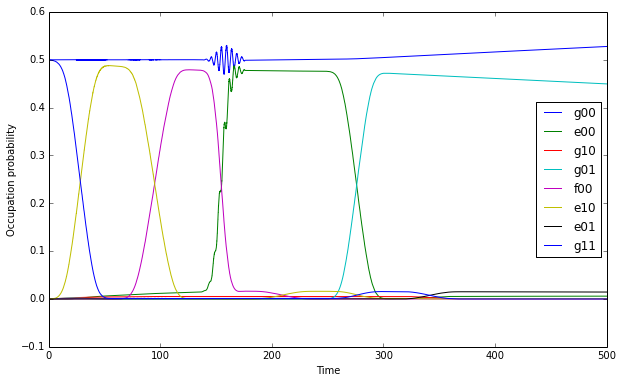

In [84]:
def GHZ_ideal_tomo():
    sys_para = SystemParameters()
    sys_para.update_total_time(500)
    
    tomo_measure_e = []
        
    state_ops = sys_para.state_operators()
    
    ghz_ideal = (Qobj(sys_para.H0).eigenstates()[1][0]+Qobj(sys_para.H0).eigenstates()[1][8])/(np.sqrt(2))
    ghz_rho = ghz_ideal * ghz_ideal.dag()
    
    for tomo_index in range(15):
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = initiate_pulse(sys_para)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = tomo_pulse(sys_para, tomo_index, Hx_pulse, Hy_pulse, Hz_pulse, time, 2.12831034042)

        measure_e = run_experiment(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time = time, run=True, init_state = ghz_rho)
        tomo_measure_e.append(measure_e)
        
        np.save("./data/ghz_ideal_tomo", np.array(tomo_measure_e))
        
GHZ_ideal_tomo()

[ 0.49934987  0.49935094  0.49379936  0.49946856  0.99693004  0.51235318
  0.50018519  0.49946321  0.49260764  0.99664999  0.50020281  0.494422
  0.50152732  0.50151158  0.02212514]


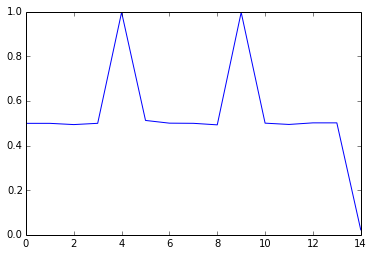

In [85]:
ghz_ideal_tomo = np.load("./data/ghz_ideal_tomo/ghz_ideal_tomo.npy")
plt.plot(ghz_ideal_tomo)
print ghz_ideal_tomo

### W state

Phase: -3.14159265359


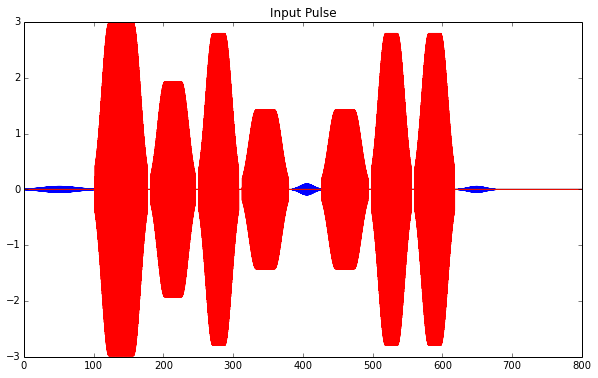

10.0%. Run time: 112.75s. Est. time left: 00:00:16:54
20.0%. Run time: 230.99s. Est. time left: 00:00:15:23
30.0%. Run time: 333.53s. Est. time left: 00:00:12:58
40.0%. Run time: 442.48s. Est. time left: 00:00:11:03
50.0%. Run time: 543.25s. Est. time left: 00:00:09:03
60.0%. Run time: 644.72s. Est. time left: 00:00:07:09
70.0%. Run time: 754.70s. Est. time left: 00:00:05:23
80.0%. Run time: 866.69s. Est. time left: 00:00:03:36
90.0%. Run time: 962.83s. Est. time left: 00:00:01:46
Total run time: 1059.82s
0.946419438191
Phase: -2.44346095279


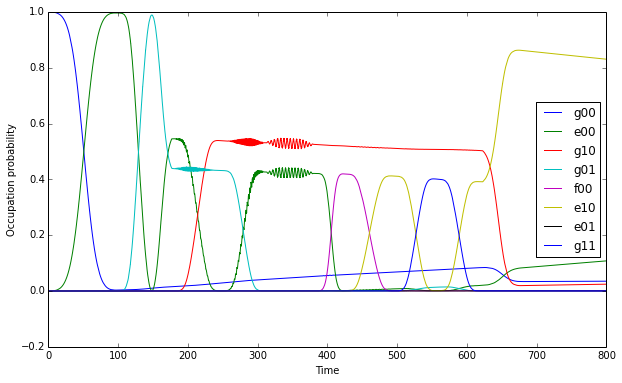

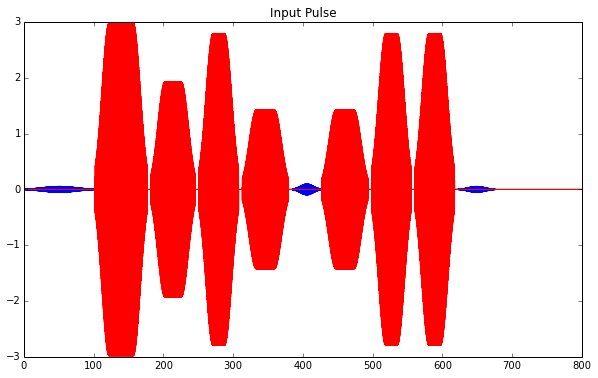

10.0%. Run time: 111.71s. Est. time left: 00:00:16:45
20.0%. Run time: 229.37s. Est. time left: 00:00:15:17
30.0%. Run time: 330.88s. Est. time left: 00:00:12:52
40.0%. Run time: 439.19s. Est. time left: 00:00:10:58
50.0%. Run time: 541.85s. Est. time left: 00:00:09:01
60.0%. Run time: 647.87s. Est. time left: 00:00:07:11
70.0%. Run time: 757.44s. Est. time left: 00:00:05:24
80.0%. Run time: 868.25s. Est. time left: 00:00:03:37
90.0%. Run time: 964.86s. Est. time left: 00:00:01:47
Total run time: 1060.90s
0.805420012844
Phase: -1.74532925199


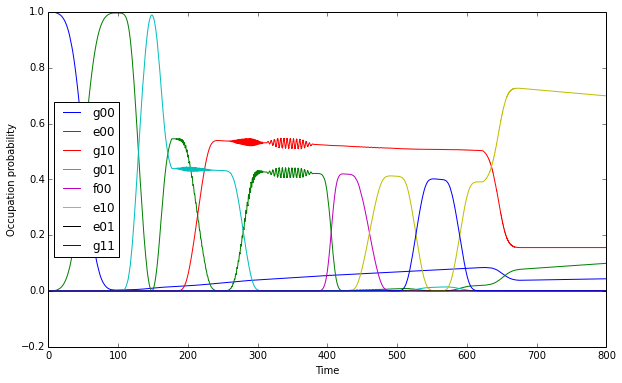

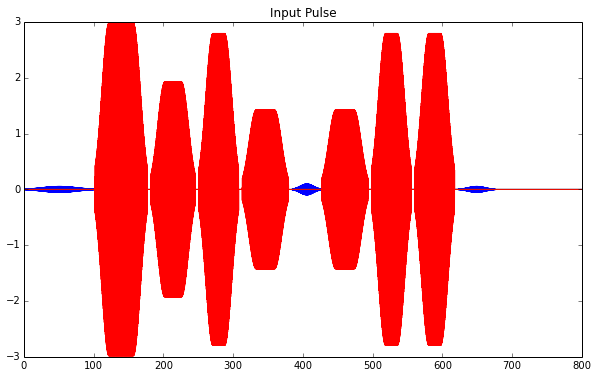

10.0%. Run time: 112.16s. Est. time left: 00:00:16:49
20.0%. Run time: 230.37s. Est. time left: 00:00:15:21
30.0%. Run time: 332.64s. Est. time left: 00:00:12:56
40.0%. Run time: 441.52s. Est. time left: 00:00:11:02
50.0%. Run time: 541.99s. Est. time left: 00:00:09:01
60.0%. Run time: 643.09s. Est. time left: 00:00:07:08
70.0%. Run time: 752.29s. Est. time left: 00:00:05:22
80.0%. Run time: 864.95s. Est. time left: 00:00:03:36
90.0%. Run time: 966.18s. Est. time left: 00:00:01:47
Total run time: 1063.12s
0.527243385158
Phase: -1.0471975512


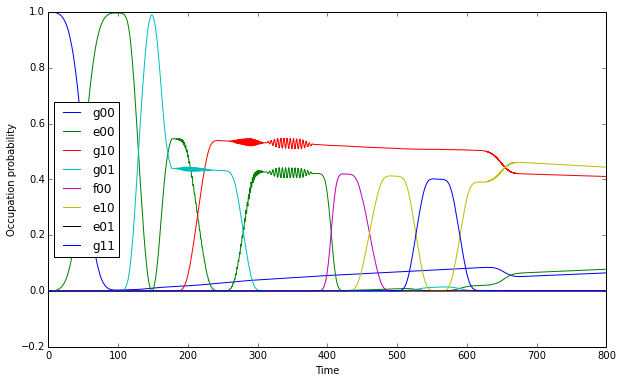

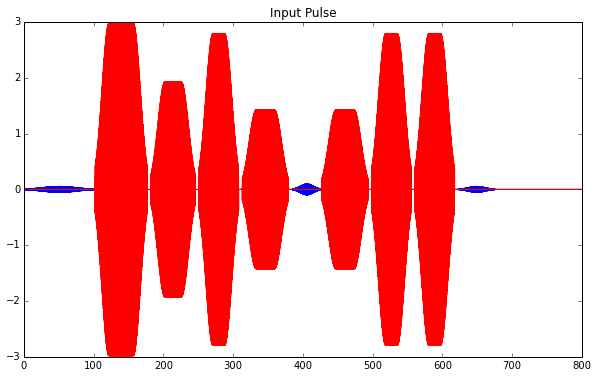

10.0%. Run time: 119.97s. Est. time left: 00:00:17:59
20.0%. Run time: 244.44s. Est. time left: 00:00:16:17
30.0%. Run time: 346.17s. Est. time left: 00:00:13:27
40.0%. Run time: 454.02s. Est. time left: 00:00:11:21
50.0%. Run time: 554.07s. Est. time left: 00:00:09:14
60.0%. Run time: 655.06s. Est. time left: 00:00:07:16
70.0%. Run time: 763.63s. Est. time left: 00:00:05:27
80.0%. Run time: 877.07s. Est. time left: 00:00:03:39
90.0%. Run time: 968.85s. Est. time left: 00:00:01:47
Total run time: 1050.30s
0.238315899025
Phase: -0.349065850399


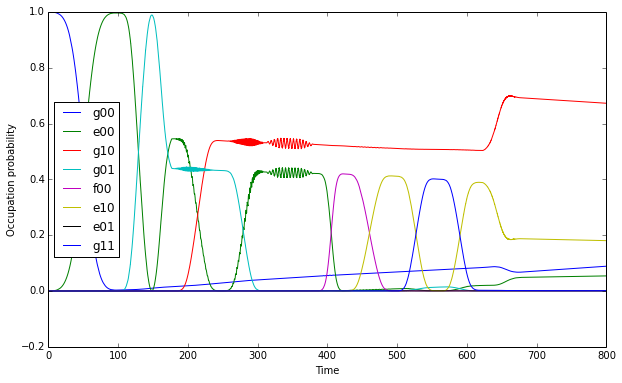

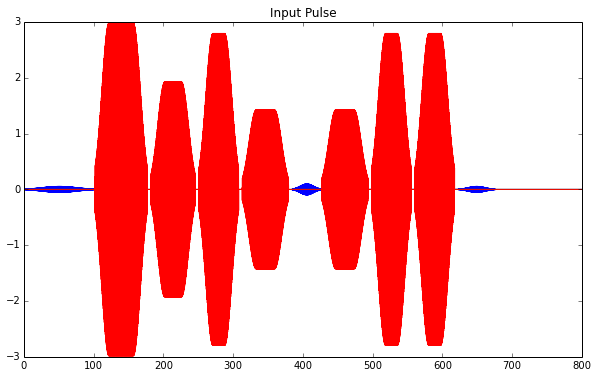

10.0%. Run time: 111.65s. Est. time left: 00:00:16:44
20.0%. Run time: 229.39s. Est. time left: 00:00:15:17
30.0%. Run time: 331.16s. Est. time left: 00:00:12:52
40.0%. Run time: 439.64s. Est. time left: 00:00:10:59
50.0%. Run time: 539.99s. Est. time left: 00:00:08:59
60.0%. Run time: 641.17s. Est. time left: 00:00:07:07
70.0%. Run time: 749.93s. Est. time left: 00:00:05:21
80.0%. Run time: 860.61s. Est. time left: 00:00:03:35
90.0%. Run time: 955.60s. Est. time left: 00:00:01:46
Total run time: 1049.50s
0.0692811903743
Phase: 0.349065850399


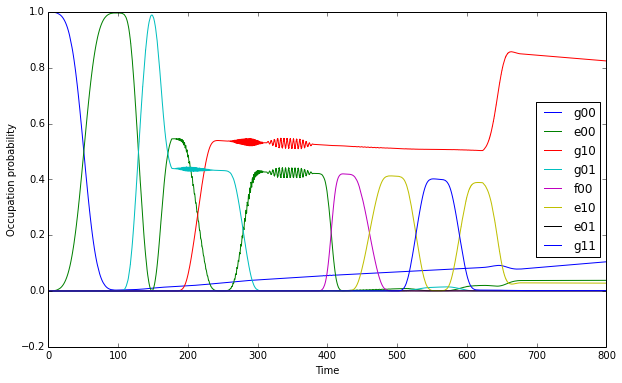

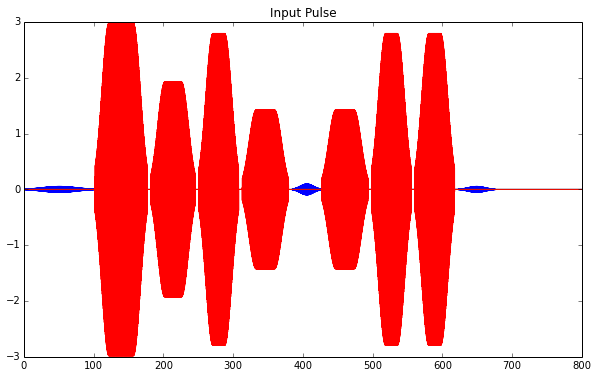

10.0%. Run time: 113.88s. Est. time left: 00:00:17:04
20.0%. Run time: 231.81s. Est. time left: 00:00:15:27
30.0%. Run time: 334.24s. Est. time left: 00:00:12:59
40.0%. Run time: 443.07s. Est. time left: 00:00:11:04
50.0%. Run time: 543.91s. Est. time left: 00:00:09:03
60.0%. Run time: 644.65s. Est. time left: 00:00:07:09
70.0%. Run time: 753.44s. Est. time left: 00:00:05:22
80.0%. Run time: 866.95s. Est. time left: 00:00:03:36
90.0%. Run time: 970.17s. Est. time left: 00:00:01:47
Total run time: 1071.79s
0.0965794853138
Phase: 1.0471975512


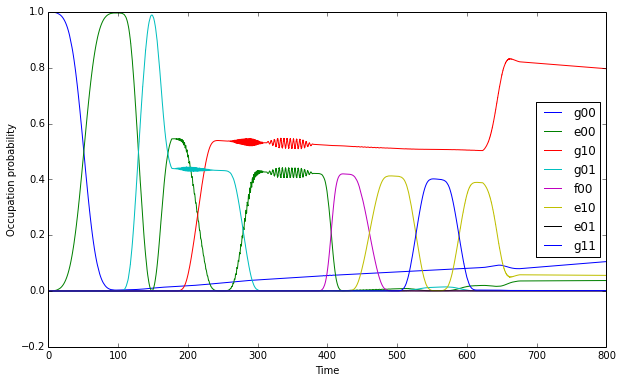

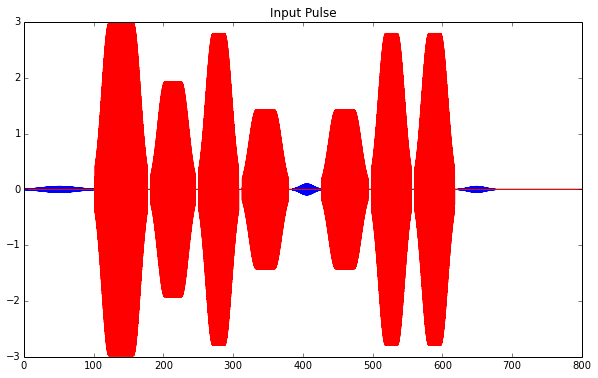

10.0%. Run time: 111.76s. Est. time left: 00:00:16:45
20.0%. Run time: 229.70s. Est. time left: 00:00:15:18
30.0%. Run time: 332.14s. Est. time left: 00:00:12:54
40.0%. Run time: 440.66s. Est. time left: 00:00:11:00
50.0%. Run time: 540.88s. Est. time left: 00:00:09:00
60.0%. Run time: 641.65s. Est. time left: 00:00:07:07
70.0%. Run time: 750.35s. Est. time left: 00:00:05:21
80.0%. Run time: 858.81s. Est. time left: 00:00:03:34
90.0%. Run time: 941.89s. Est. time left: 00:00:01:44
Total run time: 1006.79s
0.316252346932
Phase: 1.74532925199


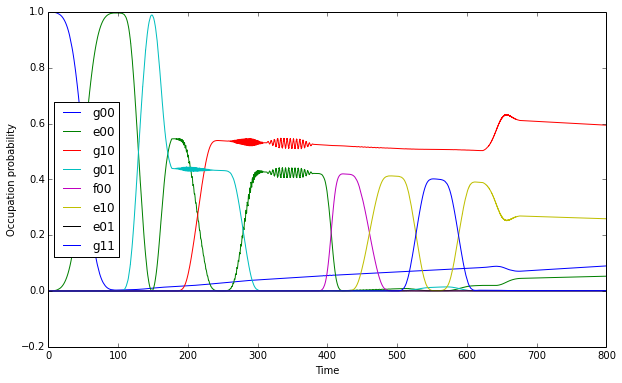

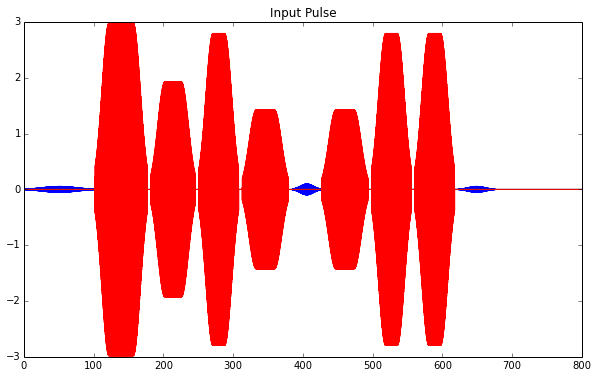

10.0%. Run time: 111.56s. Est. time left: 00:00:16:44
20.0%. Run time: 229.78s. Est. time left: 00:00:15:19
30.0%. Run time: 332.15s. Est. time left: 00:00:12:55
40.0%. Run time: 440.52s. Est. time left: 00:00:11:00
50.0%. Run time: 541.60s. Est. time left: 00:00:09:01
60.0%. Run time: 643.26s. Est. time left: 00:00:07:08
70.0%. Run time: 752.97s. Est. time left: 00:00:05:22
80.0%. Run time: 866.69s. Est. time left: 00:00:03:36
90.0%. Run time: 966.94s. Est. time left: 00:00:01:47
Total run time: 1064.14s
0.628730942154
Phase: 2.44346095279


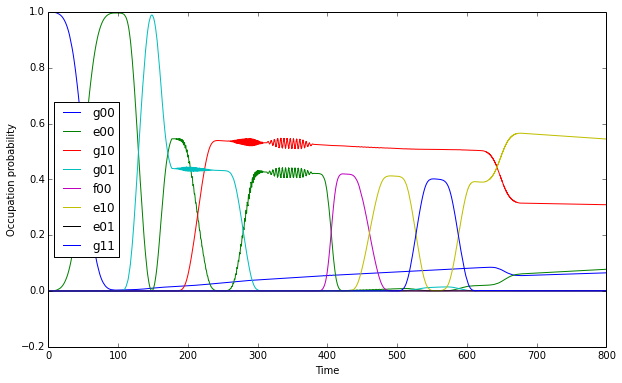

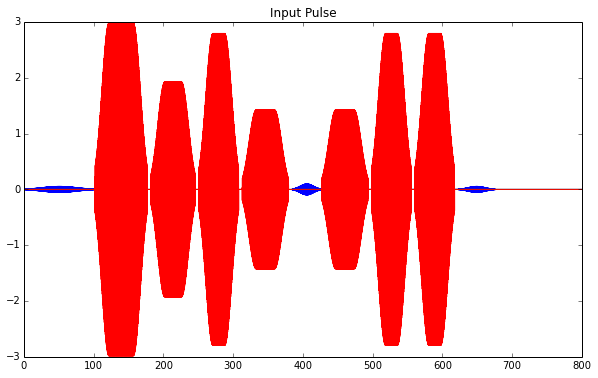

10.0%. Run time: 110.80s. Est. time left: 00:00:16:37
20.0%. Run time: 228.46s. Est. time left: 00:00:15:13
30.0%. Run time: 329.81s. Est. time left: 00:00:12:49
40.0%. Run time: 438.33s. Est. time left: 00:00:10:57
50.0%. Run time: 539.01s. Est. time left: 00:00:08:59
60.0%. Run time: 640.98s. Est. time left: 00:00:07:07
70.0%. Run time: 754.29s. Est. time left: 00:00:05:23
80.0%. Run time: 860.77s. Est. time left: 00:00:03:35
90.0%. Run time: 957.85s. Est. time left: 00:00:01:46
Total run time: 1051.97s
0.877940122557
Phase: 3.14159265359


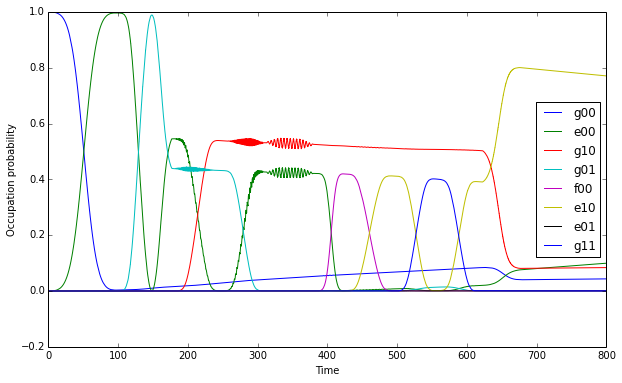

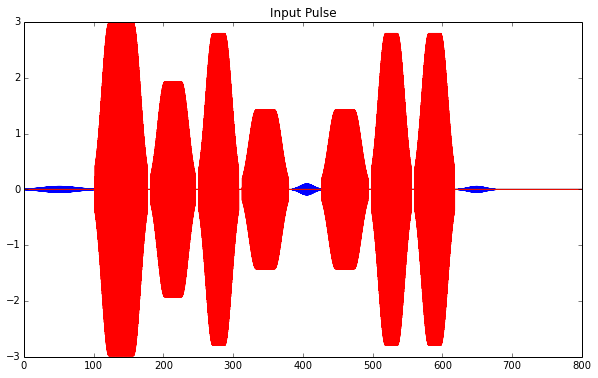

10.0%. Run time: 112.02s. Est. time left: 00:00:16:48
20.0%. Run time: 230.36s. Est. time left: 00:00:15:21
30.0%. Run time: 332.40s. Est. time left: 00:00:12:55
40.0%. Run time: 440.87s. Est. time left: 00:00:11:01
50.0%. Run time: 541.98s. Est. time left: 00:00:09:01
60.0%. Run time: 643.10s. Est. time left: 00:00:07:08
70.0%. Run time: 752.50s. Est. time left: 00:00:05:22
80.0%. Run time: 863.83s. Est. time left: 00:00:03:35
90.0%. Run time: 959.42s. Est. time left: 00:00:01:46
Total run time: 1055.91s
0.946419438145


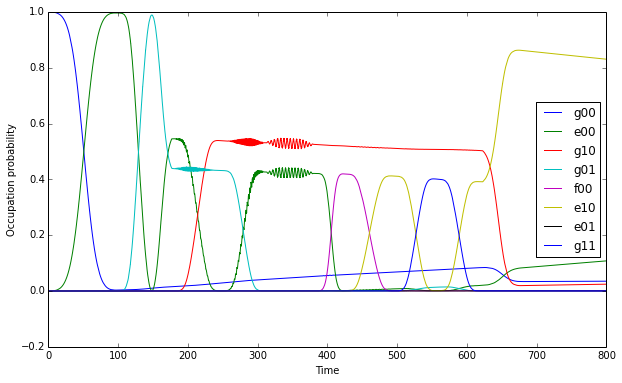

In [87]:
def W_XX_phase_sweep():
    sys_para = SystemParameters()
    sys_para.update_total_time(800)
    
    tomo_measure_e = []
    
    def prepare_W(sys_para):
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = initiate_pulse(sys_para)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_3pi2_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    for phase in np.linspace(-np.pi,np.pi,10):
        print "Phase: " + str(phase)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = prepare_W(sys_para)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CX(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse, phase = phase)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse,phase = np.pi/2)

        measure_e = run_experiment(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time = time, run=True)
        tomo_measure_e.append(measure_e)
        
        np.save("./data/W_xx_phase_sweep", np.array(tomo_measure_e))
        
W_XX_phase_sweep()

Phase: -3.14159265359


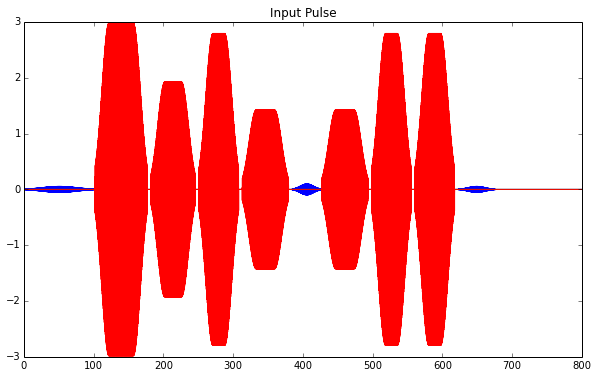

10.0%. Run time: 112.10s. Est. time left: 00:00:16:48
20.0%. Run time: 230.63s. Est. time left: 00:00:15:22
30.0%. Run time: 333.60s. Est. time left: 00:00:12:58
40.0%. Run time: 442.86s. Est. time left: 00:00:11:04
50.0%. Run time: 541.82s. Est. time left: 00:00:09:01
60.0%. Run time: 643.28s. Est. time left: 00:00:07:08
70.0%. Run time: 752.66s. Est. time left: 00:00:05:22
80.0%. Run time: 860.64s. Est. time left: 00:00:03:35
90.0%. Run time: 929.73s. Est. time left: 00:00:01:43
Total run time: 992.17s
0.0555942055408
Phase: -2.44346095279


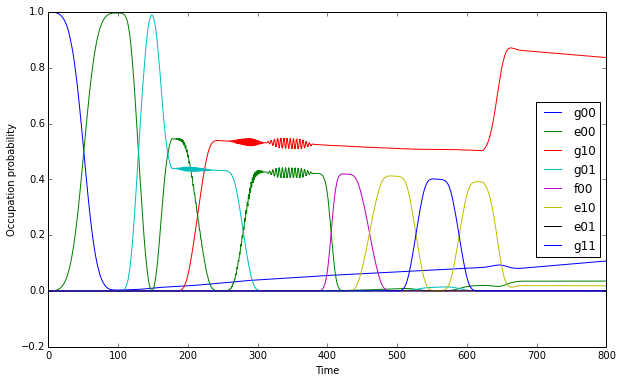

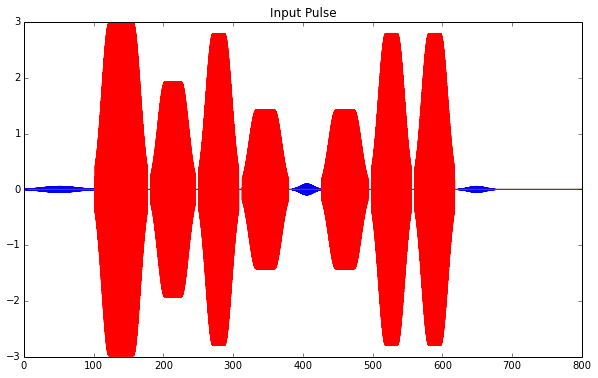

10.0%. Run time: 111.13s. Est. time left: 00:00:16:40
20.0%. Run time: 229.16s. Est. time left: 00:00:15:16
30.0%. Run time: 331.77s. Est. time left: 00:00:12:54
40.0%. Run time: 440.86s. Est. time left: 00:00:11:01
50.0%. Run time: 539.73s. Est. time left: 00:00:08:59
60.0%. Run time: 641.26s. Est. time left: 00:00:07:07
70.0%. Run time: 751.50s. Est. time left: 00:00:05:22
80.0%. Run time: 859.90s. Est. time left: 00:00:03:34
90.0%. Run time: 936.08s. Est. time left: 00:00:01:44
Total run time: 1002.05s
0.191224495701
Phase: -1.74532925199


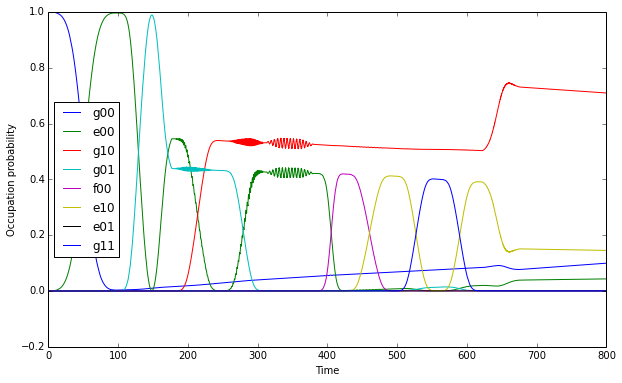

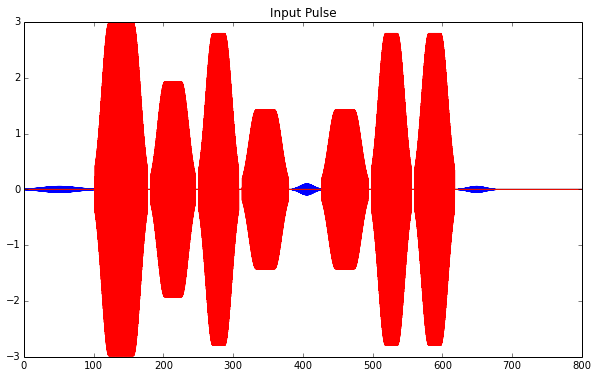

10.0%. Run time: 111.96s. Est. time left: 00:00:16:47
20.0%. Run time: 229.43s. Est. time left: 00:00:15:17
30.0%. Run time: 331.63s. Est. time left: 00:00:12:53
40.0%. Run time: 440.22s. Est. time left: 00:00:11:00
50.0%. Run time: 538.84s. Est. time left: 00:00:08:58
60.0%. Run time: 640.87s. Est. time left: 00:00:07:07
70.0%. Run time: 753.00s. Est. time left: 00:00:05:22
80.0%. Run time: 868.91s. Est. time left: 00:00:03:37
90.0%. Run time: 967.77s. Est. time left: 00:00:01:47
Total run time: 1065.07s
0.4668200857
Phase: -1.0471975512


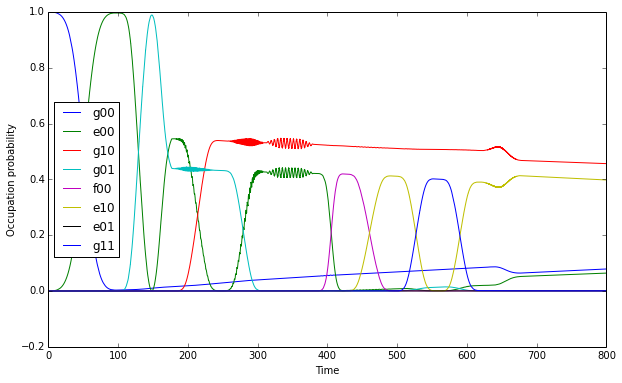

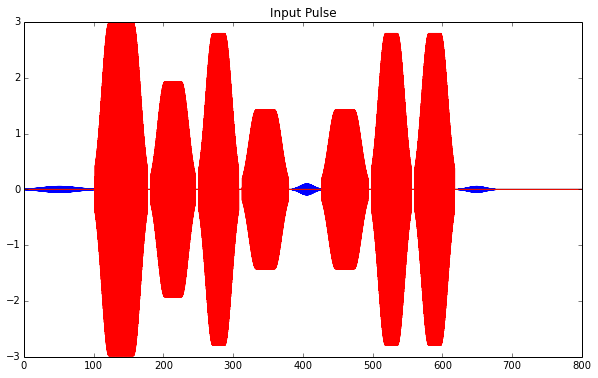

10.0%. Run time: 111.48s. Est. time left: 00:00:16:43
20.0%. Run time: 229.22s. Est. time left: 00:00:15:16
30.0%. Run time: 331.39s. Est. time left: 00:00:12:53
40.0%. Run time: 439.74s. Est. time left: 00:00:10:59
50.0%. Run time: 538.23s. Est. time left: 00:00:08:58
60.0%. Run time: 640.01s. Est. time left: 00:00:07:06
70.0%. Run time: 749.84s. Est. time left: 00:00:05:21
80.0%. Run time: 862.12s. Est. time left: 00:00:03:35
90.0%. Run time: 960.91s. Est. time left: 00:00:01:46
Total run time: 1058.34s
0.758110725965
Phase: -0.349065850399


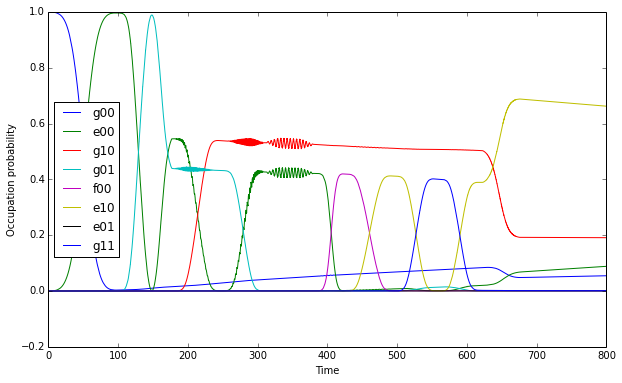

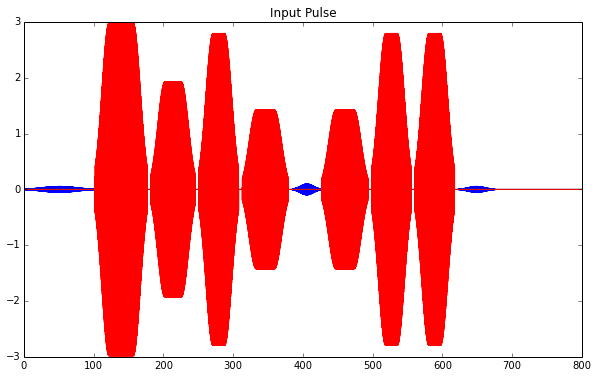

10.0%. Run time: 111.76s. Est. time left: 00:00:16:45
20.0%. Run time: 229.89s. Est. time left: 00:00:15:19
30.0%. Run time: 332.09s. Est. time left: 00:00:12:54
40.0%. Run time: 442.57s. Est. time left: 00:00:11:03
50.0%. Run time: 541.38s. Est. time left: 00:00:09:01
60.0%. Run time: 643.11s. Est. time left: 00:00:07:08
70.0%. Run time: 752.96s. Est. time left: 00:00:05:22
80.0%. Run time: 862.03s. Est. time left: 00:00:03:35
90.0%. Run time: 960.89s. Est. time left: 00:00:01:46
Total run time: 1058.18s
0.932560041904
Phase: 0.349065850399


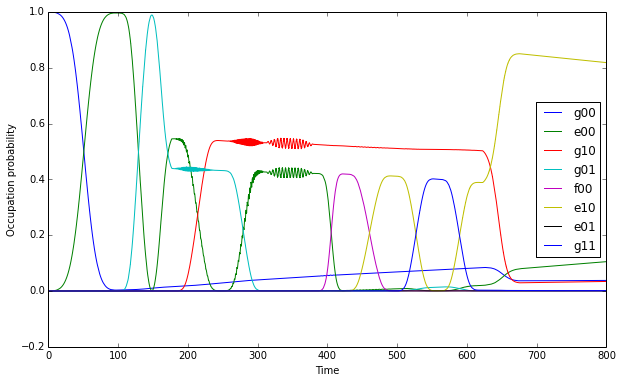

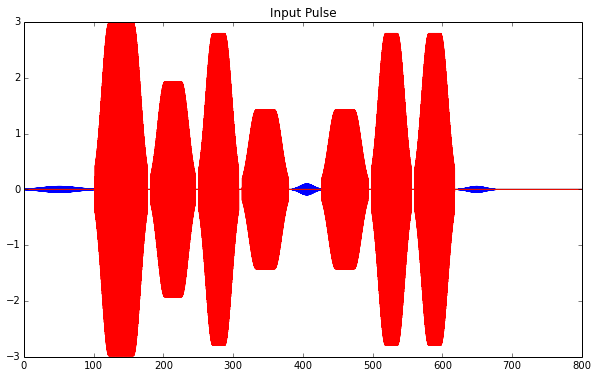

10.0%. Run time: 111.24s. Est. time left: 00:00:16:41
20.0%. Run time: 228.91s. Est. time left: 00:00:15:15
30.0%. Run time: 335.37s. Est. time left: 00:00:13:02
40.0%. Run time: 443.85s. Est. time left: 00:00:11:05
50.0%. Run time: 542.55s. Est. time left: 00:00:09:02
60.0%. Run time: 643.98s. Est. time left: 00:00:07:09
70.0%. Run time: 753.66s. Est. time left: 00:00:05:22
80.0%. Run time: 866.19s. Est. time left: 00:00:03:36
90.0%. Run time: 965.77s. Est. time left: 00:00:01:47
Total run time: 1063.36s
0.91004739682
Phase: 1.0471975512


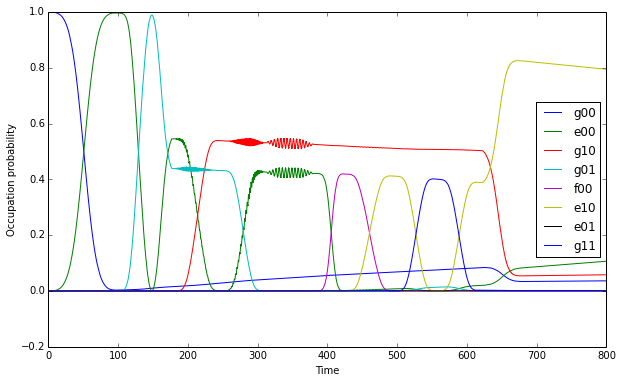

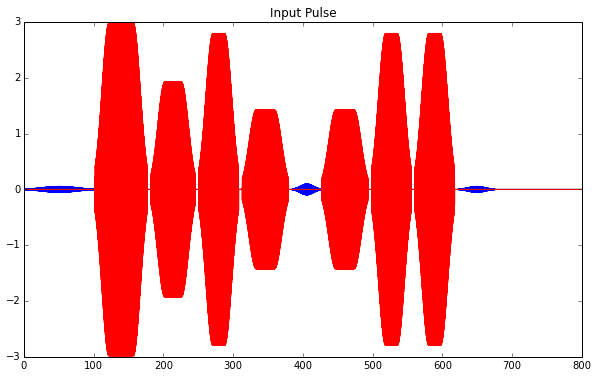

10.0%. Run time: 111.67s. Est. time left: 00:00:16:44
20.0%. Run time: 235.48s. Est. time left: 00:00:15:41
30.0%. Run time: 337.93s. Est. time left: 00:00:13:08
40.0%. Run time: 446.45s. Est. time left: 00:00:11:09
50.0%. Run time: 544.78s. Est. time left: 00:00:09:04
60.0%. Run time: 646.12s. Est. time left: 00:00:07:10
70.0%. Run time: 755.66s. Est. time left: 00:00:05:23
80.0%. Run time: 864.24s. Est. time left: 00:00:03:36
90.0%. Run time: 961.63s. Est. time left: 00:00:01:46
Total run time: 1059.04s
0.692506714946
Phase: 1.74532925199


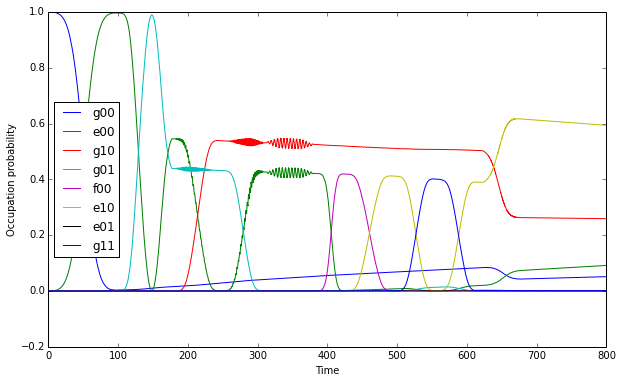

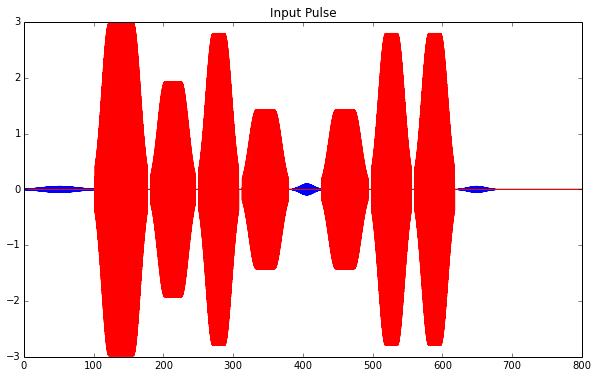

10.0%. Run time: 111.88s. Est. time left: 00:00:16:46
20.0%. Run time: 229.59s. Est. time left: 00:00:15:18
30.0%. Run time: 331.74s. Est. time left: 00:00:12:54
40.0%. Run time: 440.12s. Est. time left: 00:00:11:00
50.0%. Run time: 538.27s. Est. time left: 00:00:08:58
60.0%. Run time: 640.23s. Est. time left: 00:00:07:06
70.0%. Run time: 750.30s. Est. time left: 00:00:05:21
80.0%. Run time: 862.07s. Est. time left: 00:00:03:35
90.0%. Run time: 961.90s. Est. time left: 00:00:01:46
Total run time: 1059.98s
0.381240668431
Phase: 2.44346095279


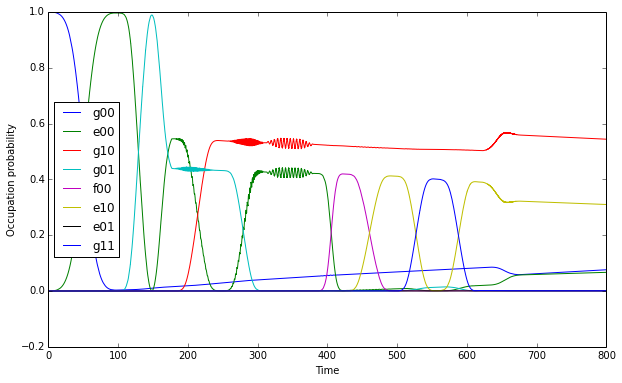

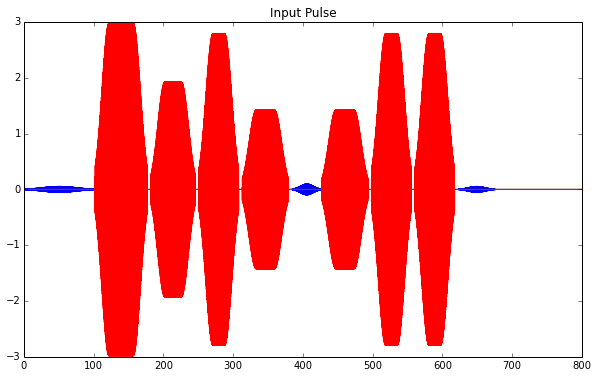

10.0%. Run time: 111.92s. Est. time left: 00:00:16:47
20.0%. Run time: 229.69s. Est. time left: 00:00:15:18
30.0%. Run time: 331.85s. Est. time left: 00:00:12:54
40.0%. Run time: 440.50s. Est. time left: 00:00:11:00
50.0%. Run time: 538.76s. Est. time left: 00:00:08:58
60.0%. Run time: 640.31s. Est. time left: 00:00:07:06
70.0%. Run time: 749.93s. Est. time left: 00:00:05:21
80.0%. Run time: 856.01s. Est. time left: 00:00:03:34
90.0%. Run time: 931.02s. Est. time left: 00:00:01:43
Total run time: 996.70s
0.12911865609
Phase: 3.14159265359


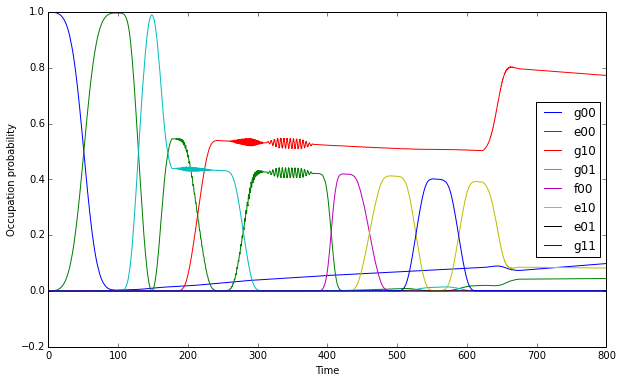

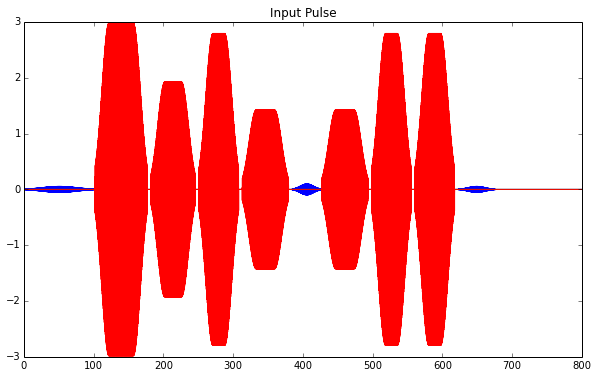

10.0%. Run time: 110.76s. Est. time left: 00:00:16:36
20.0%. Run time: 227.96s. Est. time left: 00:00:15:11
30.0%. Run time: 330.20s. Est. time left: 00:00:12:50
40.0%. Run time: 438.99s. Est. time left: 00:00:10:58
50.0%. Run time: 537.52s. Est. time left: 00:00:08:57
60.0%. Run time: 639.63s. Est. time left: 00:00:07:06
70.0%. Run time: 748.94s. Est. time left: 00:00:05:20
80.0%. Run time: 857.06s. Est. time left: 00:00:03:34
90.0%. Run time: 925.96s. Est. time left: 00:00:01:42
Total run time: 987.58s
0.0555941786566


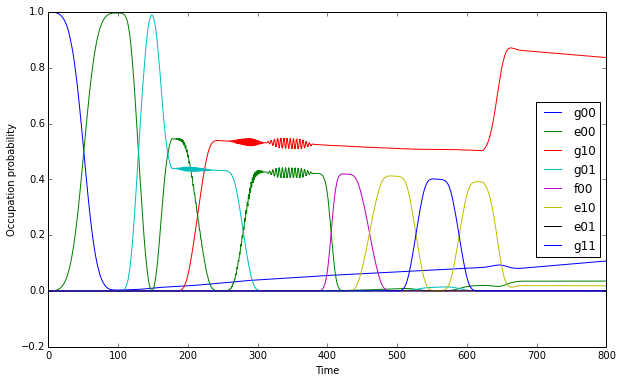

In [91]:
def W_YY_phase_sweep():
    sys_para = SystemParameters()
    sys_para.update_total_time(800)
    
    tomo_measure_e = []
    
    def prepare_W(sys_para):
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = initiate_pulse(sys_para)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_pi_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_3pi2_pulse)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb2_pi_pulse)
        return [Hx_pulse,Hy_pulse,Hz_pulse,time]
    
    for phase in np.linspace(-np.pi,np.pi,10):
        print "Phase: " + str(phase)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = prepare_W(sys_para)
        [Hx_pulse,Hy_pulse,Hz_pulse,time] = CY(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time)
        time = Hz_pulse.add_defined_pulse(time=time,pulse=sb1_pi_pulse, phase = phase)
        time = Hx_pulse.add_defined_pulse(time=time,pulse=ge_half_pi_pulse)

        measure_e = run_experiment(sys_para, Hx_pulse, Hy_pulse, Hz_pulse, time = time, run=True)
        tomo_measure_e.append(measure_e)
        
        np.save("./data/W_yy_phase_sweep", np.array(tomo_measure_e))
        
W_YY_phase_sweep()

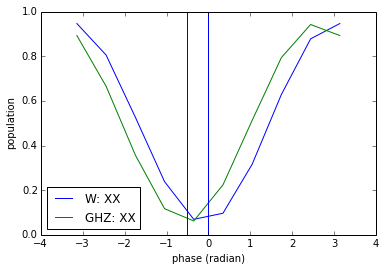

In [89]:
w_phase_sweep = np.load("./data/W_xx_phase_sweep/W_xx_phase_sweep.npy")
plt.plot(np.linspace(-np.pi,np.pi,10),w_phase_sweep ,label='W: XX')

ghz_xx_phase_sweep = np.load("./data/ghz_xx_phase_sweep/ghz_xx_phase_sweep.npy")
plt.plot(np.linspace(-np.pi,np.pi,10),ghz_xx_phase_sweep,label='GHZ: XX')

plt.axvline(0)
plt.axvline(-0.5)

plt.ylabel("population")
plt.xlabel("phase (radian)")
plt.ylabel("population")
plt.xlabel("phase (radian)")
plt.legend(loc='0')
